In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import time  # 計算程式執行時間
from sklearn import preprocessing, metrics
import scipy
import keras
from keras.layers import Dense, LSTM, Dropout, concatenate
from keras.models import Sequential, load_model
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
path = 'data_is_here/'
data1 = pd.read_csv(path+'Enterovirus_Outpatient_Hospitalization.csv')
data2 = pd.read_csv(path+'Enterovirus_Emergency.csv')
# data3 = pd.read_csv(path+'3_地區年齡性別統計表-腸病毒感染併發重症.csv')
# data4 = pd.read_csv(path+'4_社區腸病毒檢驗資料.csv')

In [3]:
print(data1.shape)
print(data1.縣市.unique())
print('')
# print(data1.年齡別.value_counts())
del data1['Unnamed: 0']
data1.head(5)

(110473, 8)
['台中市' '台北市' '台東縣' '台南市' '宜蘭縣' '花蓮縣' '金門縣' '屏東縣' '苗栗縣' '桃園市' '高雄市' '基隆市'
 '雲林縣' '新北市' '新竹市' '新竹縣' '嘉義市' '嘉義縣' '彰化縣' '南投縣' '連江縣' '澎湖縣']



,年,週,就診類別,年齡別,縣市,腸病毒健保就診人次,健保就診總人次
0,2008,14,住院,0-2,台中市,0,105
1,2008,14,住院,0-2,台北市,2,151
2,2008,14,住院,0-2,台東縣,0,14
3,2008,14,住院,0-2,台南市,0,20
4,2008,14,住院,0-2,宜蘭縣,0,44


In [4]:
print(data2.shape)
print('')
# print(data2.年齡別.value_counts())
del data2['Unnamed: 0']
data2.tail()

(41236, 6)



,年,週,年齡別,縣市,腸病毒急診就診人次
41231,2018,11,1-3,台中市,8
41232,2018,11,1-3,台南市,4
41233,2018,12,4-6,屏東縣,1
41234,2018,12,7-15,台北市,3
41235,2018,12,7-15,桃園市,1


In [5]:
# print(data3.shape)
# print('')
# data3.head(3)

(989, 9)



,確定病名,發病年份,發病週別,縣市,鄉鎮,性別,是否為境外移入,年齡層,確定病例數
0,腸病毒感染併發重症,2003,2,台南市,麻豆區,F,否,1,1
1,腸病毒感染併發重症,2005,30,新北市,深坑區,M,否,2,1
2,腸病毒感染併發重症,2008,18,彰化縣,北斗鎮,M,否,1,1


In [6]:
# print(data4.shape)
# print('')
# data4.head(5)

(534, 13)



,收件年,收件週,CA陽性檢體數,CB陽性檢體數,ECHO陽性檢體數,EV68陽性檢體數,EV71陽性檢體數,NPEV陽性檢體數,Rhinovirus陽性檢體數,Poliovirus陽性檢體數,檢驗件數,總陽性檢體數,送檢陽性率
0,2008,1,6,3,0,NaN,0,0,NaN,0,105,9,8.571429
1,2008,2,8,2,0,NaN,3,5,NaN,0,135,18,13.333333
2,2008,3,9,5,2,NaN,6,3,NaN,1,155,26,16.774194
3,2008,4,14,2,3,NaN,3,5,NaN,0,170,27,15.882353
4,2008,5,10,3,4,NaN,1,2,NaN,0,128,20,15.625000


#### 第一種預測方式，使用過去的就診人次對未來進行預測，產生未來四週的感染人次(Base on上週的資料對下一週做預測，各週間互相關聯)
#### 滾動式預測 rolled forecast

In [8]:
starttime = time.clock()
#########################
data_enter = pd.DataFrame(columns=['year','week','n_enter'])  # Create a new DataFrame

for yr in np.arange(2008,2018):
    for wk in np.arange(1,54):
        N_Out = sum(data1[(data1.年==yr) & (data1.週==wk) & (data1.就診類別=='門診')]['腸病毒健保就診人次'])
        N_Eme = sum(data2[(data2.年==yr) & (data2.週==wk)]['腸病毒急診就診人次'])
        temp = pd.DataFrame([[yr, wk, N_Out+N_Eme]], columns=['year','week','n_enter'])
        data_enter = pd.concat([data_enter, temp], axis=0)

data_enter = data_enter[data_enter.n_enter != 0]
data_enter = data_enter.reset_index(drop=True)
#########################
endtime = time.clock() ; print('It cost',round(endtime-starttime,3),'sec')


def Convert_DateTime(data):
    year = str(int(data.year))
    week = str(int(data.week))
    if len(str(int(data.week))) < 2:
        week = '0' + str(int(data.week))
    return year + '.' + week


data_enter['YearWeek'] = data_enter.apply(Convert_DateTime, axis=1)
data_enter = data_enter[['YearWeek','n_enter']]

It cost 6.179 sec


In [10]:
data_enter.tail()

,YearWeek,n_enter
518,2017.48,10597.0
519,2017.49,9537.0
520,2017.50,7941.0
521,2017.51,7562.0
522,2017.52,7116.0


It cost 5.954 sec


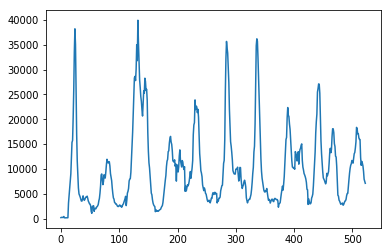

In [11]:
starttime = time.clock()
#########################
data_enter = pd.DataFrame(columns=['year','week','n_enter'])  # Create a new DataFrame

for yr in np.arange(2008,2018):
    for wk in np.arange(1,54):
        N_Out = sum(data1[(data1.年==yr) & (data1.週==wk) & (data1.就診類別=='門診')]['腸病毒健保就診人次'])
        N_Eme = sum(data2[(data2.年==yr) & (data2.週==wk)]['腸病毒急診就診人次'])
        temp = pd.DataFrame([[yr, wk, N_Out+N_Eme]], columns=['year','week','n_enter'])
        data_enter = pd.concat([data_enter, temp], axis=0)

data_enter = data_enter[data_enter.n_enter != 0]
data_enter = data_enter.reset_index(drop=True)
#########################
endtime = time.clock() ; print('It cost',round(endtime-starttime,3),'sec')


def Convert_DateTime(data):
    year = str(int(data.year))
    week = str(int(data.week))
    if len(str(int(data.week))) < 2:
        week = '0' + str(int(data.week))
    return year + '.' + week


data_enter['YearWeek'] = data_enter.apply(Convert_DateTime, axis=1)
data_enter = data_enter[['YearWeek','n_enter']]
# data_enter['n_enter'] = preprocessing.scale(data_enter['n_enter'])  # 此方法不知如何inverse回去原始數值

values = data_enter['n_enter'].values.astype('float32')
plt.plot(values)
plt.show()

values = values.reshape(len(values), 1)
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
data_enter['n_enter'] = scaled

In [13]:
def window_data(data, window_size):
    x = []
    y = []
    
    for i in data.index:
        if i+window_size <= max(data.index):
            x.append(data.n_enter[i:i+window_size].values.tolist())
            y.append(data.n_enter[i+window_size])
    
    return x, y


window_size = 7  # 一個半月的週數
x, y = window_data(data_enter, window_size = window_size)
print(len(x), len(y))

516 516


In [14]:
x_train = np.array(x[:419]) ; x_train = x_train[:,np.newaxis,:]
y_train = np.array(y[:419])

x_val = np.array(x[419:471]) ; x_val = x_val[:,np.newaxis,:]
y_val = np.array(y[419:471])

x_test = np.array(x[471:]) ; x_test = x_test[:,np.newaxis,:]
y_test = np.array(y[471:])

print("x_train size: {}".format(x_train.shape))
print("y_train size: {}".format(y_train.shape))
print("x_val size: {}".format(x_val.shape))
print("y_val size: {}".format(y_val.shape))
print("x_test size: {}".format(x_test.shape))
print("y_test size: {}".format(y_test.shape))

model = Sequential()
model.add(LSTM(1000, input_shape=(x_train.shape[1], x_train.shape[2])))
# model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(x_train, y_train, epochs=50, batch_size=100, validation_data=(x_val, y_val))

x_train size: (419, 1, 7)
y_train size: (419,)
x_val size: (52, 1, 7)
y_val size: (52,)
x_test size: (45, 1, 7)
y_test size: (45,)
Train on 419 samples, validate on 52 samples
Epoch 1/50
419/419 [==============================] - 2s 5ms/step - loss: 0.0914 - val_loss: 0.0491
Epoch 2/50
419/419 [==============================] - 0s 117us/step - loss: 0.0333 - val_loss: 0.0187
Epoch 3/50
419/419 [==============================] - 0s 120us/step - loss: 0.0190 - val_loss: 0.0249
Epoch 4/50
419/419 [==============================] - 0s 120us/step - loss: 0.0246 - val_loss: 0.0213
Epoch 5/50
419/419 [==============================] - 0s 120us/step - loss: 0.0181 - val_loss: 0.0150
Epoch 6/50
419/419 [==============================] - 0s 122us/step - loss: 0.0150 - val_loss: 0.0157
Epoch 7/50
419/419 [==============================] - 0s 119us/step - loss: 0.0154 - val_loss: 0.0149
Epoch 8/50
419/419 [==============================] - 0s 116us/step - loss: 0.0139 - val_loss: 0.0120
Epoch 9/50

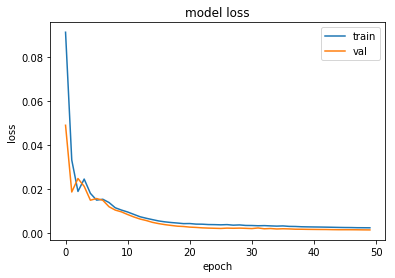

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'], loc='upper right')
plt.show()

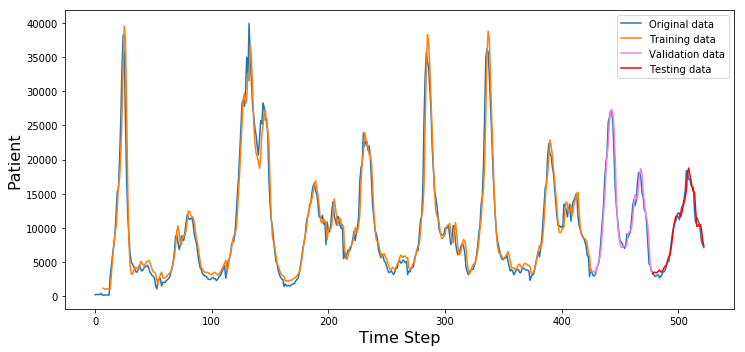

In [16]:
plt.figure(figsize=(12, 5.5))
plt.plot(scaler.inverse_transform(data_enter.n_enter.values.reshape(len(data_enter.n_enter),1)), 
         label='Original data')
plt.plot([x for x in range(window_size, window_size+419)], scaler.inverse_transform(model.predict(x_train)),
         label='Training data')
plt.plot([x for x in range(window_size+419, window_size+419+52)], scaler.inverse_transform(model.predict(x_val)),
         'violet', label='Validation data')
plt.plot([x for x in range(window_size+419+52, len(data_enter))], scaler.inverse_transform(model.predict(x_test)),
         'r', label='Testing data')
plt.legend(fontsize=10)
plt.xlabel('Time Step', size=16)
plt.ylabel('Patient', size=16)
# plt.show()  # 如果要savefig, 就不能同時使用plt.show

In [17]:
x_val[-1].reshape(1,1,7)[0,0,1:]

array([ 0.31222811,  0.30807915,  0.26196283,  0.19072643,  0.1150142 ,
        0.11038748])

In [18]:
# 以 X validation最後一筆去預測接下來四週各別的腸病毒感染人次
wk_1_feature = model.predict(x_val[-1].reshape(1,1,7))
wk_2_feature = model.predict(np.concatenate((x_val[-1].reshape(1,1,7)[0,0,1:], wk_1_feature[0])).reshape(1,1,7))
wk_3_feature = model.predict(np.concatenate((x_val[-1].reshape(1,1,7)[0,0,2:], wk_1_feature[0], wk_2_feature[0])).reshape(1,1,7))
wk_4_feature = model.predict(np.concatenate((x_val[-1].reshape(1,1,7)[0,0,3:], wk_1_feature[0], wk_2_feature[0], wk_3_feature[0])).reshape(1,1,7))

print('未來第一週的腸病毒感染人次: {}'.format(int(round(scaler.inverse_transform(wk_1_feature)[0,0]))))
print('未來第二週的腸病毒感染人次: {}'.format(int(round(scaler.inverse_transform(wk_2_feature)[0,0]))))
print('未來第三週的腸病毒感染人次: {}'.format(int(round(scaler.inverse_transform(wk_3_feature)[0,0]))))
print('未來第四週的腸病毒感染人次: {}'.format(int(round(scaler.inverse_transform(wk_4_feature)[0,0]))))

print('RMSE: {:.3e}'.format(np.square(history.history['loss'][-1])))

未來第一週的腸病毒感染人次: 3661
未來第二週的腸病毒感染人次: 3236
未來第三週的腸病毒感染人次: 3207
未來第四週的腸病毒感染人次: 3443
RMSE: 5.881e-06


#### 找出用過去幾週去對未來進行預測能有較佳的RMSE

It cost 5.458 sec


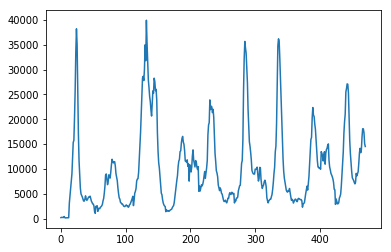

In [19]:
starttime = time.clock()
#########################
data_enter = pd.DataFrame(columns=['year','week','n_enter'])  # Create a new DataFrame

# for yr in np.arange(2008,2018):
for yr in np.arange(2008,2017):
    for wk in np.arange(1,54):
        N_Out = sum(data1[(data1.年==yr) & (data1.週==wk) & (data1.就診類別=='門診')]['腸病毒健保就診人次'])
        N_Eme = sum(data2[(data2.年==yr) & (data2.週==wk)]['腸病毒急診就診人次'])
        temp = pd.DataFrame([[yr, wk, N_Out+N_Eme]], columns=['year','week','n_enter'])
        data_enter = pd.concat([data_enter, temp], axis=0)

data_enter = data_enter[data_enter.n_enter != 0]
data_enter = data_enter.reset_index(drop=True)
#########################
endtime = time.clock() ; print('It cost',round(endtime-starttime,3),'sec')


def Convert_DateTime(data):
    year = str(int(data.year))
    week = str(int(data.week))
    if len(str(int(data.week))) < 2:
        week = '0' + str(int(data.week))
    return year + '.' + week


data_enter['YearWeek'] = data_enter.apply(Convert_DateTime, axis=1)
data_enter = data_enter[['YearWeek','n_enter']]
# data_enter['n_enter'] = preprocessing.scale(data_enter['n_enter'])  # 此方法不知如何inverse回去原始數值

values = data_enter['n_enter'].values.astype('float32')
plt.plot(values)
plt.show()

values = values.reshape(len(values), 1)
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
data_enter['n_enter'] = scaled

In [20]:
data_enter.tail()

,YearWeek,n_enter
466,2016.48,0.451105
467,2016.49,0.450627
468,2016.50,0.431240
469,2016.51,0.375569
470,2016.52,0.361286


In [7]:
def window_data(data, window_size):
    x = []
    y = []
    
    for i in data.index:
        if i+window_size <= max(data.index):
            x.append(data.n_enter[i:i+window_size].values.tolist())
            y.append(data.n_enter[i+window_size])
    
    return x, y



starttime = time.clock()
#########################
RMSE_list = []

# for window_size in [2, 4, 6, 8, 10, 13, 26, 48]:
# for window_size in np.arange(2, 49):
#     # window_size = 2
#     x, y = window_data(data_enter, window_size = window_size)

#     Num_total = len(y)
#     x_train = np.array(x[:Num_total-3]) ; x_train = x_train[:,np.newaxis,:]
#     y_train_4wk = []
#     y_train_4wk.append(y[0:Num_total-3])
#     y_train_4wk.append(y[1:Num_total-2])
#     y_train_4wk.append(y[2:Num_total-1])
#     y_train_4wk.append(y[3:Num_total])
#     y_train_4wk = np.array(y_train_4wk).T
    
#     x_train = np.array(x[:419]) ; x_train = x_train[:,np.newaxis,:]
#     y_train_4wk = []
#     y_train_4wk.append(y[0:419])
#     y_train_4wk.append(y[1:419+1])
#     y_train_4wk.append(y[2:419+2])
#     y_train_4wk.append(y[3:419+3])
#     y_train_4wk = np.array(y_train_4wk).T

#     x_val = np.array(x[419:471-3]) ; x_val = x_val[:,np.newaxis,:]
#     y_val_4wk = []
#     y_val_4wk.append(y[419:471-3])
#     y_val_4wk.append(y[419+1:471-2])
#     y_val_4wk.append(y[419+2:471-1])
#     y_val_4wk.append(y[419+3:471])
#     y_val_4wk = np.array(y_val_4wk).T

#     x_test = np.array(x[471:Num_total-3]) ; x_test = x_test[:,np.newaxis,:]
#     y_test_4wk = []
#     y_test_4wk.append(y[471:Num_total-3])
#     y_test_4wk.append(y[471+1:Num_total-2])
#     y_test_4wk.append(y[471+2:Num_total-1])
#     y_test_4wk.append(y[471+3:Num_total])
#     y_test_4wk = np.array(y_test_4wk).T

#     print("x_train size: {}".format(x_train.shape))
#     print("y_train_4wk size: {}".format(np.shape(y_train_4wk)))
#     print("x_val size: {}".format(x_val.shape))
#     print("y_val_4wk size: {}".format(np.shape(y_val_4wk)))
#     print("x_test size: {}".format(x_test.shape))
#     print("y_test_4wk size: {}".format(np.shape(y_test_4wk)))

#     model1 = Sequential()
#     model1.add(LSTM(750, input_shape=(x_train.shape[1], x_train.shape[2])))
#     # model1.add(Dropout(0.3))
#     model1.add(Dense(4))
#     model1.compile(loss='mean_squared_error', optimizer='adam')
#     history1 = model1.fit(x_train, y_train_4wk, epochs=50, batch_size=50)
#     RMSE_list.append(np.square(history1.history['loss'][-1]))

#########################
endtime = time.clock() ; print('It cost',round(endtime-starttime,3),'sec')

It cost 0.0 sec


In [8]:
RMSE_list

[]

Text(0,0.5,'RMSE')

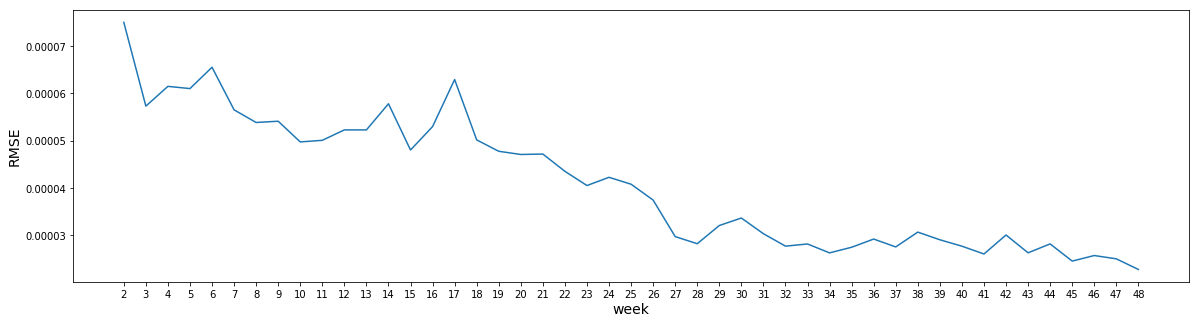

In [10]:
plt.figure(figsize=(20,5))
plt.plot(RMSE_list)
plt.xticks(np.arange(0,47), np.arange(2,49))
plt.xlabel('week', size=14)
plt.ylabel('RMSE', size=14)

Text(0,0.5,'RMSE')

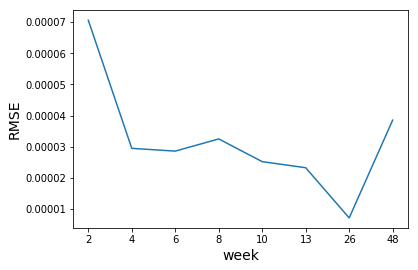

In [9]:
plt.plot(RMSE_list)
plt.xticks(np.arange(0,8), [2,4,6,8,10,13,26,48])
plt.xlabel('week', size=14)
plt.ylabel('RMSE', size=14)

#### 第二種預測方式，使用過去的就診人次對未來進行預測，產生未來四週的感染人次(一次給出4個neuron)

It cost 5.88 sec


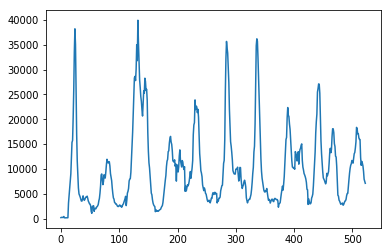

In [6]:
starttime = time.clock()
#########################
data_enter = pd.DataFrame(columns=['year','week','n_enter'])  # Create a new DataFrame

for yr in np.arange(2008,2018):
    for wk in np.arange(1,54):
        N_Out = sum(data1[(data1.年==yr) & (data1.週==wk) & (data1.就診類別=='門診')]['腸病毒健保就診人次'])
        N_Eme = sum(data2[(data2.年==yr) & (data2.週==wk)]['腸病毒急診就診人次'])
        temp = pd.DataFrame([[yr, wk, N_Out+N_Eme]], columns=['year','week','n_enter'])
        data_enter = pd.concat([data_enter, temp], axis=0)

data_enter = data_enter[data_enter.n_enter != 0]
data_enter = data_enter.reset_index(drop=True)
#########################
endtime = time.clock() ; print('It cost',round(endtime-starttime,3),'sec')


def Convert_DateTime(data):
    year = str(int(data.year))
    week = str(int(data.week))
    if len(str(int(data.week))) < 2:
        week = '0' + str(int(data.week))
    return year + '.' + week


data_enter['YearWeek'] = data_enter.apply(Convert_DateTime, axis=1)
data_enter = data_enter[['YearWeek','n_enter']]
# data_enter['n_enter'] = preprocessing.scale(data_enter['n_enter'])  # 此方法不知如何inverse回去原始數值

values = data_enter['n_enter'].values.astype('float32')
plt.plot(values)
plt.show()

values = values.reshape(len(values), 1)
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
data_enter['n_enter'] = scaled

In [7]:
Del_YW = ['2008.01', '2008.02', '2008.03', '2008.04', '2008.05', '2008.06',
          '2008.07', '2008.08', '2008.09', '2008.10', '2008.11', '2008.12', '2008.13']
data_enter = data_enter[-data_enter.YearWeek.isin(Del_YW)].reset_index(drop=True)
data_enter.head()

,YearWeek,n_enter
0,2008.14,0.075058
1,2008.15,0.112047
2,2008.16,0.148030
3,2008.17,0.187533
4,2008.18,0.222887


In [8]:
def window_data(data, window_size):
    x = []
    y = []
    
    for i in data.index:
        if i+window_size <= max(data.index):
            x.append(data.n_enter[i:i+window_size].values.tolist())
            y.append(data.n_enter[i+window_size])
    
    return x, y


window_size = 26
x, y = window_data(data_enter, window_size = window_size)
print(len(x), len(y))

484 484


In [9]:
# Num_total = len(y)
x_train = np.array(x[0:(405-window_size-3)]) ; x_train = x_train[:,np.newaxis,:]
y_train_4wk = []
y_train_4wk.append(y[0:(405-window_size-3)])
y_train_4wk.append(y[1:(405-window_size-2)])
y_train_4wk.append(y[2:(405-window_size-1)])
y_train_4wk.append(y[3:(405-window_size)])
y_train_4wk = np.array(y_train_4wk).T

x_val = np.array(x[(405-window_size):(458-window_size-3)]) ; x_val = x_val[:,np.newaxis,:]
y_val_4wk = []
y_val_4wk.append(y[(405-window_size):(458-window_size-3)])
y_val_4wk.append(y[(405-window_size+1):(458-window_size-2)])
y_val_4wk.append(y[(405-window_size+2):(458-window_size-1)])
y_val_4wk.append(y[(405-window_size+3):(458-window_size)])
y_val_4wk = np.array(y_val_4wk).T

x_test = np.array(x[(458-window_size):(510-window_size-3)]) ; x_test = x_test[:,np.newaxis,:]
y_test_4wk = []
y_test_4wk.append(y[(458-window_size):(510-window_size-3)])
y_test_4wk.append(y[(458-window_size+1):(510-window_size-2)])
y_test_4wk.append(y[(458-window_size+2):(510-window_size-1)])
y_test_4wk.append(y[(458-window_size+3):(510-window_size)])
y_test_4wk = np.array(y_test_4wk).T

print("x_train size: {}".format(x_train.shape))
print("y_train_4wk size: {}".format(np.shape(y_train_4wk)))
print("x_val size: {}".format(x_val.shape))
print("y_val_4wk size: {}".format(np.shape(y_val_4wk)))
print("x_test size: {}".format(x_test.shape))
print("y_test_4wk size: {}".format(np.shape(y_test_4wk)))

model1 = Sequential()
model1.add(LSTM(800, input_shape=(x_train.shape[1], x_train.shape[2])))
# model1.add(Dropout(0.3))
model1.add(Dense(4))
model1.compile(loss='mean_squared_error', optimizer='adam')

history1 = model1.fit(x_train, y_train_4wk, epochs=100, batch_size=50, validation_data=(x_val, y_val_4wk))

x_train size: (376, 1, 26)
y_train_4wk size: (376, 4)
x_val size: (50, 1, 26)
y_val_4wk size: (50, 4)
x_test size: (49, 1, 26)
y_test_4wk size: (49, 4)
Train on 376 samples, validate on 50 samples
Epoch 1/100
376/376 [==============================] - 2s 5ms/step - loss: 0.0715 - val_loss: 0.0350
Epoch 2/100
376/376 [==============================] - 0s 126us/step - loss: 0.0412 - val_loss: 0.0324
Epoch 3/100
376/376 [==============================] - 0s 158us/step - loss: 0.0289 - val_loss: 0.0347
Epoch 4/100
376/376 [==============================] - 0s 147us/step - loss: 0.0234 - val_loss: 0.0322
Epoch 5/100
376/376 [==============================] - 0s 153us/step - loss: 0.0193 - val_loss: 0.0286
Epoch 6/100
376/376 [==============================] - 0s 138us/step - loss: 0.0170 - val_loss: 0.0236
Epoch 7/100
376/376 [==============================] - 0s 148us/step - loss: 0.0150 - val_loss: 0.0187
Epoch 8/100
376/376 [==============================] - 0s 168us/step - loss: 0.0139 

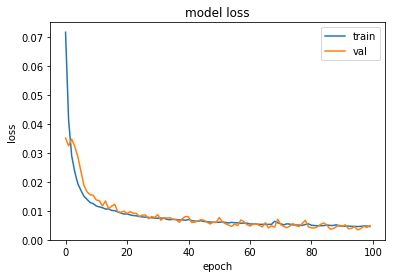

In [10]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'], loc='upper right')
plt.show()

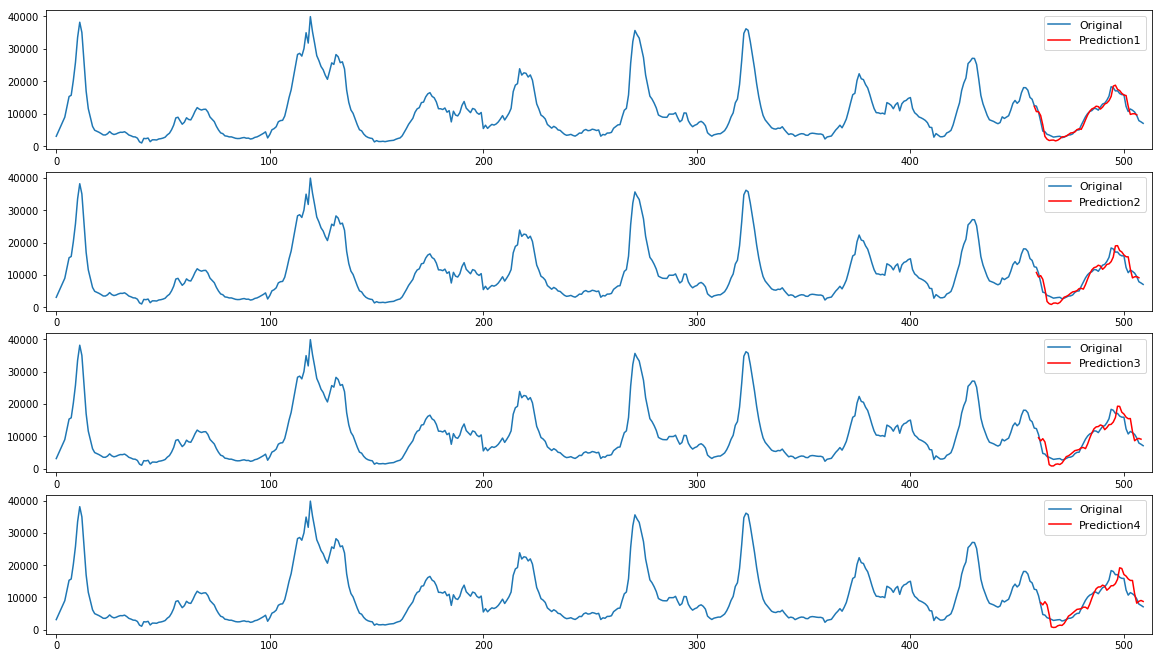

In [11]:
plt.figure(figsize=(16, 9))

plt.subplot(4,1,1)
plt.plot(scaler.inverse_transform(data_enter.n_enter.values.reshape(len(data_enter.n_enter),1)), 
         label='Original') ; plt.xlim(-5, 513)
plt.plot([x for x in range(458, 510-3)], scaler.inverse_transform(model1.predict(x_test))[:,0],
         'r', label='Prediction1')
plt.legend(fontsize=11, loc=1)

plt.subplot(4,1,2)
plt.plot(scaler.inverse_transform(data_enter.n_enter.values.reshape(len(data_enter.n_enter),1)), 
         label='Original') ; plt.xlim(-5, 513)
plt.plot([x for x in range(458+1, 510-2)], scaler.inverse_transform(model1.predict(x_test))[:,1],
         'r', label='Prediction2')
plt.legend(fontsize=11, loc=1)

plt.subplot(4,1,3)
plt.plot(scaler.inverse_transform(data_enter.n_enter.values.reshape(len(data_enter.n_enter),1)), 
         label='Original') ; plt.xlim(-5, 513)
plt.plot([x for x in range(458+2, 510-1)], scaler.inverse_transform(model1.predict(x_test))[:,2],
         'r', label='Prediction3')
plt.legend(fontsize=11, loc=1)

plt.subplot(4,1,4)
plt.plot(scaler.inverse_transform(data_enter.n_enter.values.reshape(len(data_enter.n_enter),1)), 
         label='Original') ; plt.xlim(-5, 513)
plt.plot([x for x in range(458+3, 510)], scaler.inverse_transform(model1.predict(x_test))[:,3],
         'r', label='Prediction4')
plt.legend(fontsize=11, loc=1)

# plt.xlabel('Time Step', size=16)
# plt.ylabel('Patient', size=16)
plt.tight_layout(0.2)  # 使subplot不會擠在一起
plt.savefig('LSTM_taiwan_no_feature.png')

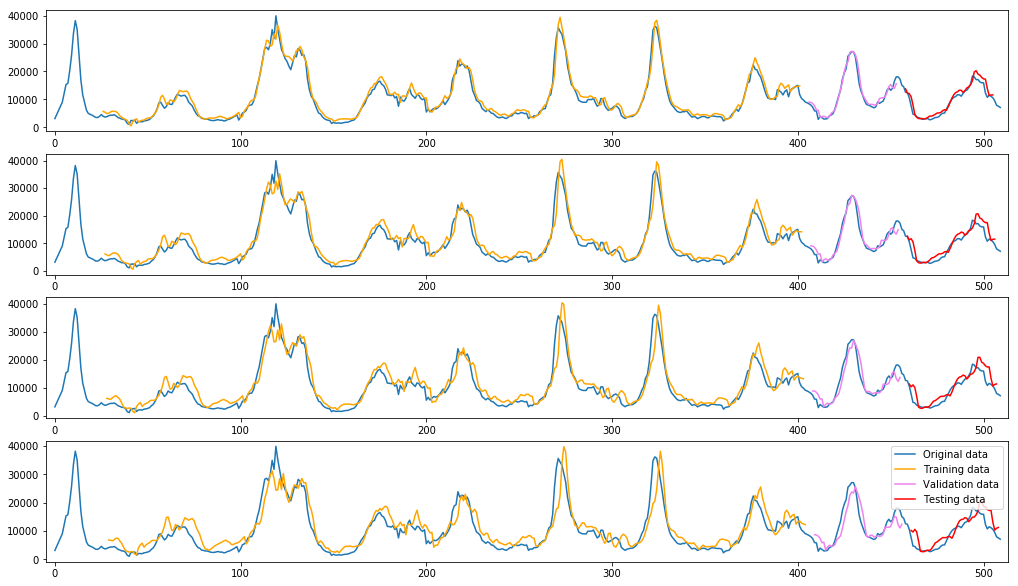

In [12]:
plt.figure(figsize=(14, 8))

plt.subplot(4,1,1)
plt.plot(scaler.inverse_transform(data_enter.n_enter.values.reshape(len(data_enter.n_enter),1)), 
         label='Original data') ; plt.xlim(-5,513)
plt.plot([x for x in range(window_size, 405-3)], scaler.inverse_transform(model1.predict(x_train))[:,0],
         'orange', label='Training data')
plt.plot([x for x in range(406, 457-3)], scaler.inverse_transform(model1.predict(x_val))[:,0],
         'violet', label='Validation data')      # -3是因為validation不可橫跨到testing的範圍(2017年), 所以要扣掉(預測的最大週數-1)
plt.plot([x for x in range(458, 509-3)], scaler.inverse_transform(model1.predict(x_test))[:,0],
         'r', label='Testing data')

plt.subplot(4,1,2)
plt.plot(scaler.inverse_transform(data_enter.n_enter.values.reshape(len(data_enter.n_enter),1)), 
         label='Original data') ; plt.xlim(-5,513)
plt.plot([x for x in range(window_size+1, 405-2)], scaler.inverse_transform(model1.predict(x_train))[:,1],
         'orange', label='Training data')
plt.plot([x for x in range(406+1, 457-2)], scaler.inverse_transform(model1.predict(x_val))[:,1],
         'violet', label='Validation data')
plt.plot([x for x in range(458+1, 509-2)], scaler.inverse_transform(model1.predict(x_test))[:,1],
         'r', label='Testing data')

plt.subplot(4,1,3)
plt.plot(scaler.inverse_transform(data_enter.n_enter.values.reshape(len(data_enter.n_enter),1)), 
         label='Original data') ; plt.xlim(-5,513)
plt.plot([x for x in range(window_size+2, 405-1)], scaler.inverse_transform(model1.predict(x_train))[:,2],
         'orange', label='Training data')
plt.plot([x for x in range(406+2, 457-1)], scaler.inverse_transform(model1.predict(x_val))[:,2],
         'violet', label='Validation data')
plt.plot([x for x in range(458+2, 509-1)], scaler.inverse_transform(model1.predict(x_test))[:,2],
         'r', label='Testing data')

plt.subplot(4,1,4)
plt.plot(scaler.inverse_transform(data_enter.n_enter.values.reshape(len(data_enter.n_enter),1)), 
         label='Original data') ; plt.xlim(-5,513)
plt.plot([x for x in range(window_size+3, 405)], scaler.inverse_transform(model1.predict(x_train))[:,3],
         'orange', label='Training data')
plt.plot([x for x in range(406+3, 457)], scaler.inverse_transform(model1.predict(x_val))[:,3],
         'violet', label='Validation data')
plt.plot([x for x in range(458+3, 509)], scaler.inverse_transform(model1.predict(x_test))[:,3],
         'r', label='Testing data')

plt.legend(fontsize=10, loc=1)
# plt.xlabel('Time Step', size=16)
# plt.ylabel('Patient', size=16)
plt.tight_layout(0.2)  # 使subplot不會擠在一起
# plt.savefig('Overall_no_feature_TrainValiTest.png')

In [12]:
# 以 X validation最後一筆去預測接下來四週各別的腸病毒感染人次
print(scaler.inverse_transform(model1.predict(x_test[0][np.newaxis,:,:])))
print('未來第一週的腸病毒感染人次: {}'.format(int(round(scaler.inverse_transform(model1.predict(x_test[0][np.newaxis,:,:]))[0,0]))))
print('未來第二週的腸病毒感染人次: {}'.format(int(round(scaler.inverse_transform(model1.predict(x_test[0][np.newaxis,:,:]))[0,1]))))
print('未來第三週的腸病毒感染人次: {}'.format(int(round(scaler.inverse_transform(model1.predict(x_test[0][np.newaxis,:,:]))[0,2]))))
print('未來第四週的腸病毒感染人次: {}'.format(int(round(scaler.inverse_transform(model1.predict(x_test[0][np.newaxis,:,:]))[0,3]))))
print(scaler.inverse_transform(y_test_4wk[0][np.newaxis,:]))

# RMSE for wk1
y_true_wk1 = scaler.inverse_transform(y_test_4wk[:,0][np.newaxis,:])
y_pred_wk1 = scaler.inverse_transform(model1.predict(x_test)[:,0][np.newaxis,:])
print('RMSE: {:.3f}'.format((metrics.mean_squared_error(y_true_wk1, y_pred_wk1))**0.5))

# RMSE for wk2
y_true_wk2 = scaler.inverse_transform(y_test_4wk[:,1][np.newaxis,:])
y_pred_wk2 = scaler.inverse_transform(model1.predict(x_test)[:,1][np.newaxis,:])
print('RMSE: {:.3f}'.format((metrics.mean_squared_error(y_true_wk2, y_pred_wk2))**0.5))

# RMSE for wk3
y_true_wk3 = scaler.inverse_transform(y_test_4wk[:,2][np.newaxis,:])
y_pred_wk3 = scaler.inverse_transform(model1.predict(x_test)[:,2][np.newaxis,:])
print('RMSE: {:.3f}'.format((metrics.mean_squared_error(y_true_wk3, y_pred_wk3))**0.5))

# RMSE for wk4
y_true_wk4 = scaler.inverse_transform(y_test_4wk[:,3][np.newaxis,:])
y_pred_wk4 = scaler.inverse_transform(model1.predict(x_test)[:,3][np.newaxis,:])
print('RMSE: {:.3f}'.format((metrics.mean_squared_error(y_true_wk4, y_pred_wk4))**0.5))

[[ 12360.359375    10808.96386719   9588.25         8436.26464844]]
未來第一週的腸病毒感染人次: 12360
未來第二週的腸病毒感染人次: 10809
未來第三週的腸病毒感染人次: 9588
未來第四週的腸病毒感染人次: 8436
[[ 12566.  12401.  10567.   7734.]]
RMSE: 1154.690
RMSE: 1771.221
RMSE: 2086.123
RMSE: 2374.805


In [13]:
print ('未來第一周的誤差率', "%.2f" % np.mean(np.abs((y_pred_wk1-y_true_wk1)/y_true_wk1*100)), '%')
print ('未來第二周的誤差率', "%.2f" % np.mean(np.abs((y_pred_wk2-y_true_wk2)/y_true_wk2*100)), '%')
print ('未來第三周的誤差率', "%.2f" % np.mean(np.abs((y_pred_wk3-y_true_wk3)/y_true_wk3*100)), '%')
print ('未來第四周的誤差率', "%.2f" % np.mean(np.abs((y_pred_wk4-y_true_wk4)/y_true_wk4*100)), '%')

未來第一周的誤差率 13.20 %
未來第二周的誤差率 20.90 %
未來第三周的誤差率 24.90 %
未來第四周的誤差率 28.95 %


#### 第三種預測方式，沒加feature，產生六都(focus on 台北市)的未來四週感染人次(一次給出4個neuron)

In [6]:
starttime = time.clock()
#########################

data_enter = pd.DataFrame(columns=['year','week','city','n_enter'])  # Create a new DataFrame
city_taipei = ['台北市']
city_newpei = ['新北市']
city_taoy = ['桃園市']
city_taichung = ['台中市']
city_tainan = ['台南市']
city_kaoh = ['高雄市']

for yr in np.arange(2008,2018):
    for wk in np.arange(1,54):
        N_Out1 = sum(data1[(data1.年==yr) & (data1.週==wk) & (data1.就診類別=='門診') & (data1.縣市.isin(city_taipei))]['腸病毒健保就診人次'])
        N_Out2 = sum(data1[(data1.年==yr) & (data1.週==wk) & (data1.就診類別=='門診') & (data1.縣市.isin(city_newpei))]['腸病毒健保就診人次'])
        N_Out3 = sum(data1[(data1.年==yr) & (data1.週==wk) & (data1.就診類別=='門診') & (data1.縣市.isin(city_taoy))]['腸病毒健保就診人次'])
        N_Out4 = sum(data1[(data1.年==yr) & (data1.週==wk) & (data1.就診類別=='門診') & (data1.縣市.isin(city_taichung))]['腸病毒健保就診人次'])
        N_Out5 = sum(data1[(data1.年==yr) & (data1.週==wk) & (data1.就診類別=='門診') & (data1.縣市.isin(city_tainan))]['腸病毒健保就診人次'])
        N_Out6 = sum(data1[(data1.年==yr) & (data1.週==wk) & (data1.就診類別=='門診') & (data1.縣市.isin(city_kaoh))]['腸病毒健保就診人次'])
        
        N_Eme1 = sum(data2[(data2.年==yr) & (data2.週==wk) & (data2.縣市.isin(city_taipei))]['腸病毒急診就診人次'])
        N_Eme2 = sum(data2[(data2.年==yr) & (data2.週==wk) & (data2.縣市.isin(city_newpei))]['腸病毒急診就診人次'])
        N_Eme3 = sum(data2[(data2.年==yr) & (data2.週==wk) & (data2.縣市.isin(city_taoy))]['腸病毒急診就診人次'])
        N_Eme4 = sum(data2[(data2.年==yr) & (data2.週==wk) & (data2.縣市.isin(city_taichung))]['腸病毒急診就診人次'])
        N_Eme5 = sum(data2[(data2.年==yr) & (data2.週==wk) & (data2.縣市.isin(city_tainan))]['腸病毒急診就診人次'])
        N_Eme6 = sum(data2[(data2.年==yr) & (data2.週==wk) & (data2.縣市.isin(city_kaoh))]['腸病毒急診就診人次'])
        
        temp1 = pd.DataFrame([[yr, wk, '台北市', N_Out1+N_Eme1]], columns=['year','week','city','n_enter'])
        temp2 = pd.DataFrame([[yr, wk, '新北市', N_Out2+N_Eme2]], columns=['year','week','city','n_enter'])
        temp3 = pd.DataFrame([[yr, wk, '桃園市', N_Out3+N_Eme3]], columns=['year','week','city','n_enter'])
        temp4 = pd.DataFrame([[yr, wk, '台中市', N_Out4+N_Eme4]], columns=['year','week','city','n_enter'])
        temp5 = pd.DataFrame([[yr, wk, '台南市', N_Out5+N_Eme5]], columns=['year','week','city','n_enter'])
        temp6 = pd.DataFrame([[yr, wk, '高雄市', N_Out6+N_Eme6]], columns=['year','week','city','n_enter'])
        
        data_enter = pd.concat([data_enter, temp1, temp2, temp3, temp4, temp5, temp6], axis=0)

#########################
endtime = time.clock() ; print('It cost',round(endtime-starttime,3),'sec')


data_enter = data_enter[data_enter.n_enter != 0]
data_enter = data_enter.reset_index(drop=True)
# area_dummies = pd.get_dummies(data_enter.area)
# data_enter = pd.concat([data_enter,area_dummies], axis=1)

def Convert_DateTime(data):
    year = str(int(data.year))
    week = str(int(data.week))
    if len(str(int(data.week))) < 2:
        week = '0' + str(int(data.week))
    return year + '.' + week

data_enter['YearWeek'] = data_enter.apply(Convert_DateTime, axis=1)
data_enter = data_enter[['YearWeek','city','n_enter']]

It cost 51.328 sec


In [7]:
Del_YW = ['2008.01', '2008.02', '2008.03', '2008.04', '2008.05', '2008.06',
          '2008.07', '2008.08', '2008.09', '2008.10', '2008.11', '2008.12', '2008.13']
data_enter = data_enter[-data_enter.YearWeek.isin(Del_YW)].reset_index(drop=True)
data_enter.head()

,YearWeek,city,n_enter
0,2008.14,台北市,303.0
1,2008.14,新北市,339.0
2,2008.14,桃園市,241.0
3,2008.14,台中市,299.0
4,2008.14,台南市,353.0


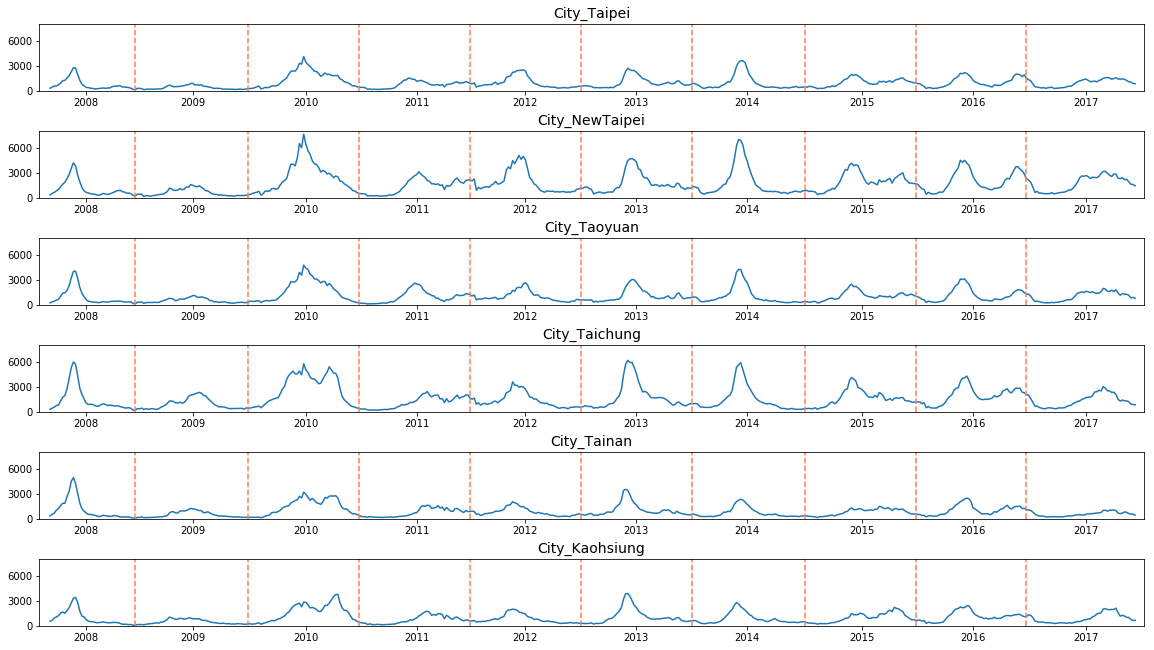

In [9]:
every_year_week = [40, 93, 145, 197, 249, 301, 354, 406, 458]
plt.figure(figsize=(16,9))

plt.subplot(6,1,1)
plt.plot(data_enter.n_enter[data_enter.city=='台北市'].values)
plt.title('City_Taipei', fontsize=14) ; plt.xlim(-5,513) ; plt.ylim(0,8000) ; plt.yticks(np.arange(0,8000,3000))
plt.xticks([17, 67, 120, 172, 223, 275, 327, 381, 433, 486], ('2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'))
for yw in every_year_week:
    plt.axvline(x=yw, color='coral', linestyle='--')
# yr_text = 2008 ; ii = 0
# for textpo in [11, 59, 113, 165, 216, 268, 320, 373, 425, 479]:
#     plt.text(textpo, 6300, str(yr_text+ii), bbox=dict(facecolor='yellow', alpha=0.25)) ; ii += 1

plt.subplot(6,1,2)
plt.plot(data_enter.n_enter[data_enter.city=='新北市'].values)
plt.title('City_NewTaipei', fontsize=14) ; plt.xlim(-5,513) ; plt.ylim(0,8000) ; plt.yticks(np.arange(0,8000,3000))
plt.xticks([17, 67, 120, 172, 223, 275, 327, 381, 433, 486], ('2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'))
for yw in every_year_week:
    plt.axvline(x=yw, color='coral', linestyle='--')

plt.subplot(6,1,3)
plt.plot(data_enter.n_enter[data_enter.city=='桃園市'].values)
plt.title('City_Taoyuan', fontsize=14) ; plt.xlim(-5,513) ; plt.ylim(0,8000) ; plt.yticks(np.arange(0,8000,3000))
plt.xticks([17, 67, 120, 172, 223, 275, 327, 381, 433, 486], ('2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'))
for yw in every_year_week:
    plt.axvline(x=yw, color='coral', linestyle='--')

plt.subplot(6,1,4)
plt.plot(data_enter.n_enter[data_enter.city=='台中市'].values)
plt.title('City_Taichung', fontsize=14) ; plt.xlim(-5,513) ; plt.ylim(0,8000) ; plt.yticks(np.arange(0,8000,3000))
plt.xticks([17, 67, 120, 172, 223, 275, 327, 381, 433, 486], ('2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'))
for yw in every_year_week:
    plt.axvline(x=yw, color='coral', linestyle='--')

plt.subplot(6,1,5)
plt.plot(data_enter.n_enter[data_enter.city=='台南市'].values)
plt.title('City_Tainan', fontsize=14) ; plt.xlim(-5,513) ; plt.ylim(0,8000) ; plt.yticks(np.arange(0,8000,3000))
plt.xticks([17, 67, 120, 172, 223, 275, 327, 381, 433, 486], ('2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'))
for yw in every_year_week:
    plt.axvline(x=yw, color='coral', linestyle='--')

plt.subplot(6,1,6)
plt.plot(data_enter.n_enter[data_enter.city=='高雄市'].values)
plt.title('City_Kaohsiung', fontsize=14) ; plt.xlim(-5,513) ; plt.ylim(0,8000) ; plt.yticks(np.arange(0,8000,3000))
plt.xticks([17, 67, 120, 172, 223, 275, 327, 381, 433, 486], ('2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'))
for yw in every_year_week:
    plt.axvline(x=yw, color='coral', linestyle='--')

plt.tight_layout(0.6)  # 使subplot不會擠在一起
# plt.savefig('Six_City_2008_2017_patient_times.png')

In [21]:
data_enter1 = data_enter[data_enter.city=='台北市'].drop('city', axis=1).reset_index(drop=True)
data_enter2 = data_enter[data_enter.city=='新北市'].drop('city', axis=1).reset_index(drop=True)
data_enter3 = data_enter[data_enter.city=='桃園市'].drop('city', axis=1).reset_index(drop=True)
data_enter4 = data_enter[data_enter.city=='台中市'].drop('city', axis=1).reset_index(drop=True)
data_enter5 = data_enter[data_enter.city=='台南市'].drop('city', axis=1).reset_index(drop=True)
data_enter6 = data_enter[data_enter.city=='高雄市'].drop('city', axis=1).reset_index(drop=True)

values1 = data_enter1['n_enter'].values.astype('float32') ; values1 = values1.reshape(len(values1), 1)
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1)) ; scaled1 = scaler.fit_transform(values1) ; data_enter1['n_enter'] = scaled1

values2 = data_enter2['n_enter'].values.astype('float32') ; values2 = values2.reshape(len(values2), 1)
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1)) ; scaled2 = scaler.fit_transform(values2) ; data_enter2['n_enter'] = scaled2

values3 = data_enter3['n_enter'].values.astype('float32') ; values3 = values3.reshape(len(values3), 1)
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1)) ; scaled3 = scaler.fit_transform(values3) ; data_enter3['n_enter'] = scaled3

values4 = data_enter4['n_enter'].values.astype('float32') ; values4 = values4.reshape(len(values4), 1)
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1)) ; scaled4 = scaler.fit_transform(values4) ; data_enter4['n_enter'] = scaled4

values5 = data_enter5['n_enter'].values.astype('float32') ; values5 = values5.reshape(len(values5), 1)
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1)) ; scaled5 = scaler.fit_transform(values5) ; data_enter5['n_enter'] = scaled5

values6 = data_enter6['n_enter'].values.astype('float32') ; values6 = values6.reshape(len(values6), 1)
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1)) ; scaled6 = scaler.fit_transform(values6) ; data_enter6['n_enter'] = scaled6

def window_data(data, window_size):
    x = []
    y = []
    
    for i in data.index:
        if i+window_size <= max(data.index):
            x.append(data.n_enter[i:i+window_size].values.tolist())
            y.append(data.n_enter[i+window_size])
    
    return x, y


window_size = 26

x1, y1 = window_data(data_enter1, window_size = window_size) ; print(len(x1), len(y1))
x2, y2 = window_data(data_enter2, window_size = window_size) ; print(len(x2), len(y2))
x3, y3 = window_data(data_enter3, window_size = window_size) ; print(len(x3), len(y3))
x4, y4 = window_data(data_enter4, window_size = window_size) ; print(len(x4), len(y4))
x5, y5 = window_data(data_enter5, window_size = window_size) ; print(len(x5), len(y5))
x6, y6 = window_data(data_enter6, window_size = window_size) ; print(len(x6), len(y6))

484 484
484 484
484 484
484 484
484 484
484 484


In [22]:
# 六都 : 台北市
# Num_total = len(y1)
x_train1 = np.array(x1[0:(405-window_size-3)]) ; x_train1 = x_train1[:,np.newaxis,:]
y_train1_4wk = []
y_train1_4wk.append(y1[0:(405-window_size-3)])
y_train1_4wk.append(y1[1:(405-window_size-2)])
y_train1_4wk.append(y1[2:(405-window_size-1)])
y_train1_4wk.append(y1[3:(405-window_size)])
y_train1_4wk = np.array(y_train1_4wk).T

x_val1 = np.array(x1[(405-window_size):(458-window_size-3)]) ; x_val1 = x_val1[:,np.newaxis,:]
y_val1_4wk = []
y_val1_4wk.append(y1[(405-window_size):(458-window_size-3)])
y_val1_4wk.append(y1[(405-window_size+1):(458-window_size-2)])
y_val1_4wk.append(y1[(405-window_size+2):(458-window_size-1)])
y_val1_4wk.append(y1[(405-window_size+3):(458-window_size)])
y_val1_4wk = np.array(y_val1_4wk).T

x_test1 = np.array(x1[(458-window_size):(510-window_size-3)]) ; x_test1 = x_test1[:,np.newaxis,:]
y_test1_4wk = []
y_test1_4wk.append(y1[(458-window_size):(510-window_size-3)])
y_test1_4wk.append(y1[(458-window_size+1):(510-window_size-2)])
y_test1_4wk.append(y1[(458-window_size+2):(510-window_size-1)])
y_test1_4wk.append(y1[(458-window_size+3):(510-window_size)])
y_test1_4wk = np.array(y_test1_4wk).T

print("x_train size: {}".format(x_train1.shape))
print("y_train_4wk size: {}".format(np.shape(y_train1_4wk)))
print("x_val size: {}".format(x_val1.shape))
print("y_val_4wk size: {}".format(np.shape(y_val1_4wk)))
print("x_test size: {}".format(x_test1.shape))
print("y_test_4wk size: {}".format(np.shape(y_test1_4wk)))

model2_1 = Sequential()
model2_1.add(LSTM(1000, input_shape=(x_train1.shape[1], x_train1.shape[2])))
# model2_1.add(Dropout(0.3))
model2_1.add(Dense(4))
model2_1.compile(loss='mean_squared_error', optimizer='adam')

history2_1 = model2_1.fit(x_train1, y_train1_4wk, epochs=100, batch_size=50, validation_data=(x_val1, y_val1_4wk))

x_train size: (376, 1, 26)
y_train_4wk size: (376, 4)
x_val size: (48, 1, 26)
y_val_4wk size: (48, 4)
x_test size: (48, 1, 26)
y_test_4wk size: (48, 4)
Train on 376 samples, validate on 48 samples
Epoch 1/100
376/376 [==============================] - 2s 6ms/step - loss: 0.0502 - val_loss: 0.0241
Epoch 2/100
376/376 [==============================] - 0s 215us/step - loss: 0.0319 - val_loss: 0.0219
Epoch 3/100
376/376 [==============================] - 0s 203us/step - loss: 0.0221 - val_loss: 0.0231
Epoch 4/100
376/376 [==============================] - 0s 182us/step - loss: 0.0179 - val_loss: 0.0193
Epoch 5/100
376/376 [==============================] - 0s 187us/step - loss: 0.0159 - val_loss: 0.0160
Epoch 6/100
376/376 [==============================] - 0s 183us/step - loss: 0.0143 - val_loss: 0.0135
Epoch 7/100
376/376 [==============================] - 0s 174us/step - loss: 0.0128 - val_loss: 0.0105
Epoch 8/100
376/376 [==============================] - 0s 171us/step - loss: 0.0119 

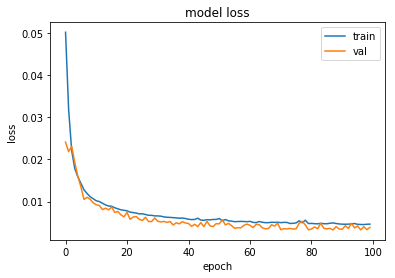

In [23]:
plt.plot(history2_1.history['loss'])
plt.plot(history2_1.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'], loc='upper right')
plt.show()

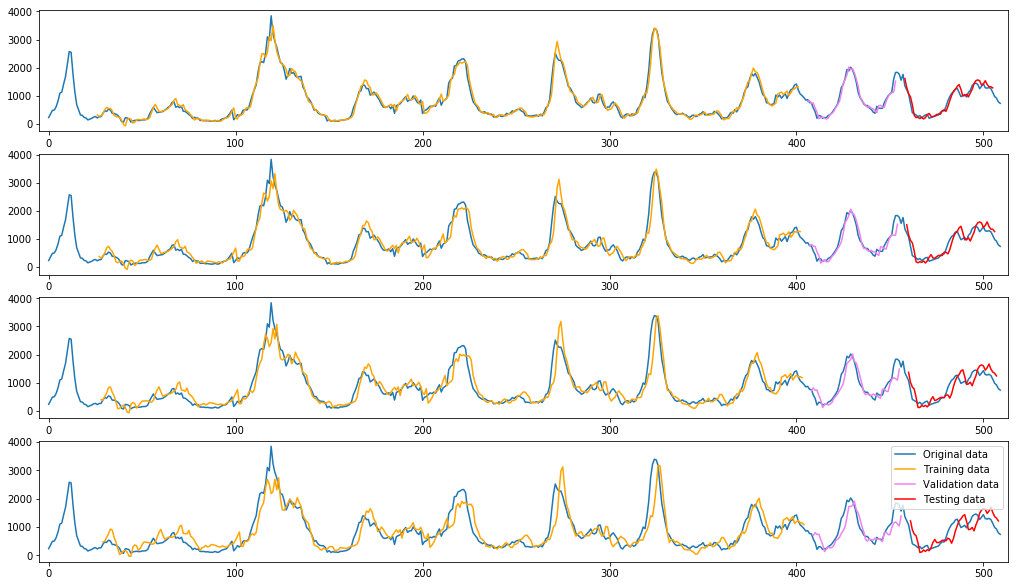

In [29]:
plt.figure(figsize=(14, 8))

plt.subplot(4,1,1)
plt.plot(scaler.inverse_transform(data_enter1.n_enter.values.reshape(len(data_enter1.n_enter),1)), 
         label='Original data') ; plt.xlim(-5, 513)
plt.plot([x for x in range(window_size, 405-3)], scaler.inverse_transform(model2_1.predict(x_train1))[:,0],
         'orange', label='Training data')
plt.plot([x for x in range(406, 457-3)], scaler.inverse_transform(model2_1.predict(x_val1))[:,0],
         'violet', label='Validation data')                      # -3是因為validation不可橫跨到testing的範圍(2017年), 所以要扣掉(預測的最大週數-1)
plt.plot([x for x in range(458, 509-3)], scaler.inverse_transform(model2_1.predict(x_test1))[:,0],
         'r', label='Testing data')

plt.subplot(4,1,2)
plt.plot(scaler.inverse_transform(data_enter1.n_enter.values.reshape(len(data_enter1.n_enter),1)), 
         label='Original data') ; plt.xlim(-5, 513)
plt.plot([x for x in range(window_size+1, 405-2)], scaler.inverse_transform(model2_1.predict(x_train1))[:,1],
         'orange', label='Training data')
plt.plot([x for x in range(406+1, 457-2)], scaler.inverse_transform(model2_1.predict(x_val1))[:,1],
         'violet', label='Validation data')
plt.plot([x for x in range(458+1, 509-2)], scaler.inverse_transform(model2_1.predict(x_test1))[:,1],
         'r', label='Testing data')

plt.subplot(4,1,3)
plt.plot(scaler.inverse_transform(data_enter1.n_enter.values.reshape(len(data_enter1.n_enter),1)), 
         label='Original data') ; plt.xlim(-5, 513)
plt.plot([x for x in range(window_size+2, 405-1)], scaler.inverse_transform(model2_1.predict(x_train1))[:,2],
         'orange', label='Training data')
plt.plot([x for x in range(406+2, 457-1)], scaler.inverse_transform(model2_1.predict(x_val1))[:,2],
         'violet', label='Validation data')
plt.plot([x for x in range(458+2, 509-1)], scaler.inverse_transform(model2_1.predict(x_test1))[:,2],
         'r', label='Testing data')

plt.subplot(4,1,4)
plt.plot(scaler.inverse_transform(data_enter1.n_enter.values.reshape(len(data_enter1.n_enter),1)), 
         label='Original data') ; plt.xlim(-5, 513)
plt.plot([x for x in range(window_size+3, 405)], scaler.inverse_transform(model2_1.predict(x_train1))[:,3],
         'orange', label='Training data')
plt.plot([x for x in range(406+3, 457)], scaler.inverse_transform(model2_1.predict(x_val1))[:,3],
         'violet', label='Validation data')
plt.plot([x for x in range(458+3, 509)], scaler.inverse_transform(model2_1.predict(x_test1))[:,3],
         'r', label='Testing data')

plt.legend(fontsize=10, loc=1)
# plt.xlabel('Time Step', size=16)
# plt.ylabel('Patient', size=16)
plt.tight_layout(0.2)  # 使subplot不會擠在一起
# plt.savefig('City_taipei_no_feature_TrainValiTest.png')

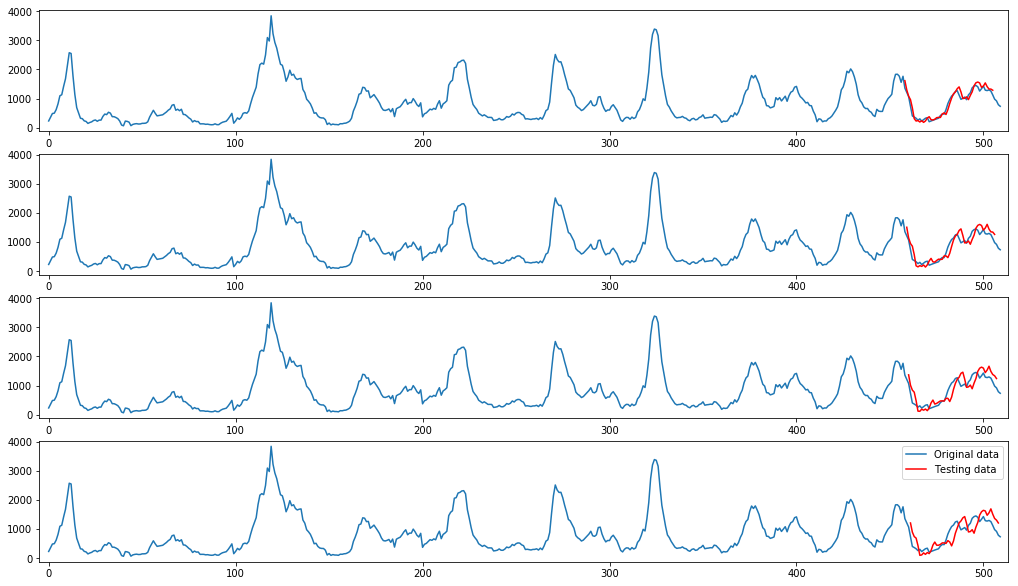

In [30]:
plt.figure(figsize=(14, 8))

plt.subplot(4,1,1)
plt.plot(scaler.inverse_transform(data_enter1.n_enter.values.reshape(len(data_enter1.n_enter),1)), 
         label='Original data') ; plt.xlim(-5, 513)
plt.plot([x for x in range(458, 509-3)], scaler.inverse_transform(model2_1.predict(x_test1))[:,0],
         'r', label='Testing data')

plt.subplot(4,1,2)
plt.plot(scaler.inverse_transform(data_enter1.n_enter.values.reshape(len(data_enter1.n_enter),1)), 
         label='Original data') ; plt.xlim(-5, 513)
plt.plot([x for x in range(458+1, 509-2)], scaler.inverse_transform(model2_1.predict(x_test1))[:,1],
         'r', label='Testing data')

plt.subplot(4,1,3)
plt.plot(scaler.inverse_transform(data_enter1.n_enter.values.reshape(len(data_enter1.n_enter),1)), 
         label='Original data') ; plt.xlim(-5, 513)
plt.plot([x for x in range(458+2, 509-1)], scaler.inverse_transform(model2_1.predict(x_test1))[:,2],
         'r', label='Testing data')

plt.subplot(4,1,4)
plt.plot(scaler.inverse_transform(data_enter1.n_enter.values.reshape(len(data_enter1.n_enter),1)), 
         label='Original data') ; plt.xlim(-5, 513)
plt.plot([x for x in range(458+3, 509)], scaler.inverse_transform(model2_1.predict(x_test1))[:,3],
         'r', label='Testing data')

plt.legend(fontsize=10, loc=1)
# plt.xlabel('Time Step', size=16)
# plt.ylabel('Patient', size=16)
plt.tight_layout(0.2)  # 使subplot不會擠在一起
# plt.savefig('City_taipei_no_feature_only_testing.png')

In [31]:
# 以 X validation最後一筆去預測接下來四週各別的腸病毒感染人次
print(scaler.inverse_transform(model2_1.predict(x_test1[0][np.newaxis,:,:])))
print('未來第一週的腸病毒感染人次: {}'.format(int(round(scaler.inverse_transform(model2_1.predict(x_test1[0][np.newaxis,:,:]))[0,0]))))
print('未來第二週的腸病毒感染人次: {}'.format(int(round(scaler.inverse_transform(model2_1.predict(x_test1[0][np.newaxis,:,:]))[0,1]))))
print('未來第三週的腸病毒感染人次: {}'.format(int(round(scaler.inverse_transform(model2_1.predict(x_test1[0][np.newaxis,:,:]))[0,2]))))
print('未來第四週的腸病毒感染人次: {}'.format(int(round(scaler.inverse_transform(model2_1.predict(x_test1[0][np.newaxis,:,:]))[0,3]))))
print(scaler.inverse_transform(y_test1_4wk[0][np.newaxis,:]))

# RMSE for wk1
y_true_wk1 = scaler.inverse_transform(y_test1_4wk[:,0][np.newaxis,:])
y_pred_wk1 = scaler.inverse_transform(model2_1.predict(x_test1)[:,0][np.newaxis,:])
print('RMSE: {:.3f}'.format((metrics.mean_squared_error(y_true_wk1, y_pred_wk1))**0.5))

# RMSE for wk2
y_true_wk2 = scaler.inverse_transform(y_test1_4wk[:,1][np.newaxis,:])
y_pred_wk2 = scaler.inverse_transform(model2_1.predict(x_test1)[:,1][np.newaxis,:])
print('RMSE: {:.3f}'.format((metrics.mean_squared_error(y_true_wk2, y_pred_wk2))**0.5))

# RMSE for wk3
y_true_wk3 = scaler.inverse_transform(y_test1_4wk[:,2][np.newaxis,:])
y_pred_wk3 = scaler.inverse_transform(model2_1.predict(x_test1)[:,2][np.newaxis,:])
print('RMSE: {:.3f}'.format((metrics.mean_squared_error(y_true_wk3, y_pred_wk3))**0.5))

# RMSE for wk4
y_true_wk4 = scaler.inverse_transform(y_test1_4wk[:,3][np.newaxis,:])
y_pred_wk4 = scaler.inverse_transform(model2_1.predict(x_test1)[:,3][np.newaxis,:])
print('RMSE: {:.3f}'.format((metrics.mean_squared_error(y_true_wk4, y_pred_wk4))**0.5))

[[ 1613.72399902  1508.52416992  1368.20874023  1209.27600098]]
未來第一週的腸病毒感染人次: 1614
未來第二週的腸病毒感染人次: 1509
未來第三週的腸病毒感染人次: 1368
未來第四週的腸病毒感染人次: 1209
[[ 1358.07336426  1211.8449707   1069.4395752    737.79736328]]
RMSE: 130.768
RMSE: 202.971
RMSE: 258.440
RMSE: 311.484


#### 第四種預測方式，產生六都的未來四週感染人次，加features

In [6]:
starttime = time.clock()
#########################

data_enter = pd.DataFrame(columns=['year','week','city','n_enter'])  # Create a new DataFrame
city_taipei = ['台北市']
city_newpei = ['新北市']
city_taoy = ['桃園市']
city_taichung = ['台中市']
city_tainan = ['台南市']
city_kaoh = ['高雄市']

for yr in np.arange(2008,2018):
    for wk in np.arange(1,54):
        N_Out1 = sum(data1[(data1.年==yr) & (data1.週==wk) & (data1.就診類別=='門診') & (data1.縣市.isin(city_taipei))]['腸病毒健保就診人次'])
        N_Out2 = sum(data1[(data1.年==yr) & (data1.週==wk) & (data1.就診類別=='門診') & (data1.縣市.isin(city_newpei))]['腸病毒健保就診人次'])
        N_Out3 = sum(data1[(data1.年==yr) & (data1.週==wk) & (data1.就診類別=='門診') & (data1.縣市.isin(city_taoy))]['腸病毒健保就診人次'])
        N_Out4 = sum(data1[(data1.年==yr) & (data1.週==wk) & (data1.就診類別=='門診') & (data1.縣市.isin(city_taichung))]['腸病毒健保就診人次'])
        N_Out5 = sum(data1[(data1.年==yr) & (data1.週==wk) & (data1.就診類別=='門診') & (data1.縣市.isin(city_tainan))]['腸病毒健保就診人次'])
        N_Out6 = sum(data1[(data1.年==yr) & (data1.週==wk) & (data1.就診類別=='門診') & (data1.縣市.isin(city_kaoh))]['腸病毒健保就診人次'])
        
        N_Eme1 = sum(data2[(data2.年==yr) & (data2.週==wk) & (data2.縣市.isin(city_taipei))]['腸病毒急診就診人次'])
        N_Eme2 = sum(data2[(data2.年==yr) & (data2.週==wk) & (data2.縣市.isin(city_newpei))]['腸病毒急診就診人次'])
        N_Eme3 = sum(data2[(data2.年==yr) & (data2.週==wk) & (data2.縣市.isin(city_taoy))]['腸病毒急診就診人次'])
        N_Eme4 = sum(data2[(data2.年==yr) & (data2.週==wk) & (data2.縣市.isin(city_taichung))]['腸病毒急診就診人次'])
        N_Eme5 = sum(data2[(data2.年==yr) & (data2.週==wk) & (data2.縣市.isin(city_tainan))]['腸病毒急診就診人次'])
        N_Eme6 = sum(data2[(data2.年==yr) & (data2.週==wk) & (data2.縣市.isin(city_kaoh))]['腸病毒急診就診人次'])
        
        temp1 = pd.DataFrame([[yr, wk, '台北市', N_Out1+N_Eme1]], columns=['year','week','city','n_enter'])
        temp2 = pd.DataFrame([[yr, wk, '新北市', N_Out2+N_Eme2]], columns=['year','week','city','n_enter'])
        temp3 = pd.DataFrame([[yr, wk, '桃園市', N_Out3+N_Eme3]], columns=['year','week','city','n_enter'])
        temp4 = pd.DataFrame([[yr, wk, '台中市', N_Out4+N_Eme4]], columns=['year','week','city','n_enter'])
        temp5 = pd.DataFrame([[yr, wk, '台南市', N_Out5+N_Eme5]], columns=['year','week','city','n_enter'])
        temp6 = pd.DataFrame([[yr, wk, '高雄市', N_Out6+N_Eme6]], columns=['year','week','city','n_enter'])
        
        data_enter = pd.concat([data_enter, temp1, temp2, temp3, temp4, temp5, temp6], axis=0)

#########################
endtime = time.clock() ; print('It cost',round(endtime-starttime,3),'sec')


data_enter = data_enter[data_enter.n_enter != 0]
data_enter = data_enter.reset_index(drop=True)
# area_dummies = pd.get_dummies(data_enter.area)
# data_enter = pd.concat([data_enter,area_dummies], axis=1)

def Convert_DateTime(data):
    year = str(int(data.year))
    week = str(int(data.week))
    if len(str(int(data.week))) < 2:
        week = '0' + str(int(data.week))
    return year + '.' + week

data_enter['YearWeek'] = data_enter.apply(Convert_DateTime, axis=1)
data_enter = data_enter[['YearWeek','city','n_enter']]

It cost 54.51 sec


In [7]:
Del_YW = ['2008.01', '2008.02', '2008.03', '2008.04', '2008.05', '2008.06',
          '2008.07', '2008.08', '2008.09', '2008.10', '2008.11', '2008.12', '2008.13']
data_enter = data_enter[-data_enter.YearWeek.isin(Del_YW)].reset_index(drop=True)
data_enter.head()

,YearWeek,city,n_enter
0,2008.14,台北市,303.0
1,2008.14,新北市,339.0
2,2008.14,桃園市,241.0
3,2008.14,台中市,299.0
4,2008.14,台南市,353.0


In [8]:
data_enter1 = data_enter[data_enter.city=='台北市'].drop('city', axis=1).reset_index(drop=True)

# Google trend
Google_trend = pd.read_csv(path + 'google_trend.csv')
Google_trend.columns = ['year', 'week', 'trend']
Google_trend = Google_trend[Google_trend.year.isin(np.arange(2008,2018,1))]
Google_trend['YearWeek'] = Google_trend.apply(Convert_DateTime, axis=1)
Google_trend = Google_trend[['YearWeek','trend']].reset_index(drop=True)

# Temperature
Temp = pd.read_csv(path + 'six_cities_temp.csv')
Temp = Temp[(Temp.地區=='臺北') & (Temp.年.isin(np.arange(2008,2018,1)))]
Temp = Temp[['年','週','max_temp','min_temp','average_temp']]
Temp.columns = ['year', 'week', 'max_temp', 'min_temp', 'mean_temp']
Temp['YearWeek'] = Temp.apply(Convert_DateTime, axis=1)
Temp = Temp[['YearWeek','max_temp','min_temp','mean_temp']].reset_index(drop=True)

# Humidity
Humid = pd.read_csv(path + 'six_cities_humidity.csv')
Humid = Humid[Humid.地區=='臺北']
Humid = Humid[['年', '週', 'average_humidity']]
Humid.columns = ['year', 'week', 'mean_humid']
Humid['YearWeek'] = Humid.apply(Convert_DateTime, axis=1)
Humid = Humid[['YearWeek','mean_humid']].reset_index(drop=True)

# Population for 0-4 ages in Taipei city
popul = pd.read_csv(path + 'Taipei_people_use.csv')
popul['popul_0_4'] = popul['0'] + popul['1'] + popul['2'] + popul['3'] + popul['4']
popul = popul[['\tyear', 'week', 'popul_0_4']]
popul.columns = ['year', 'week', 'popul_0_4']
popul['YearWeek'] = popul.apply(Convert_DateTime, axis=1)
popul = popul[['YearWeek','popul_0_4']].reset_index(drop=True)

# Air pollution
Air_pm25 = pd.read_csv(path + 'Air_polution(PM2.5max_perweek_2008_2017)/' + 'PM2.5max_perweek_2008_2017.csv')
Air_pm25.columns = ['year', 'week', 'pm25_value']
Air_pm25['YearWeek'] = Air_pm25.apply(Convert_DateTime, axis=1)
Air_pm25 = Air_pm25[['YearWeek','pm25_value']].reset_index(drop=True)

Air_pm10 = pd.read_csv(path + 'Air_polution(PM2.5max_perweek_2008_2017)/' + 'PM10max_perweek_2008_2017.csv')
Air_pm10.columns = ['year', 'week', 'pm10_value']
Air_pm10['YearWeek'] = Air_pm10.apply(Convert_DateTime, axis=1)
Air_pm10 = Air_pm10[['YearWeek','pm10_value']].reset_index(drop=True)

Air_CH4 = pd.read_csv(path + 'Air_polution(PM2.5max_perweek_2008_2017)/' + 'CH4max_perweek_2008_2017.csv')
Air_CH4.columns = ['year', 'week', 'CH4_value']
Air_CH4['YearWeek'] = Air_CH4.apply(Convert_DateTime, axis=1)
Air_CH4 = Air_CH4[['YearWeek','CH4_value']].reset_index(drop=True)

Air_CO = pd.read_csv(path + 'Air_polution(PM2.5max_perweek_2008_2017)/' + 'COmax_perweek_2008_2017.csv')
Air_CO.columns = ['year', 'week', 'CO_value']
Air_CO['YearWeek'] = Air_CO.apply(Convert_DateTime, axis=1)
Air_CO = Air_CO[['YearWeek','CO_value']].reset_index(drop=True)

Air_NO2 = pd.read_csv(path + 'Air_polution(PM2.5max_perweek_2008_2017)/' + 'NO2max_perweek_2008_2017.csv')
Air_NO2.columns = ['year', 'week', 'NO2_value']
Air_NO2['YearWeek'] = Air_NO2.apply(Convert_DateTime, axis=1)
Air_NO2 = Air_NO2[['YearWeek','NO2_value']].reset_index(drop=True)

Air_O3 = pd.read_csv(path + 'Air_polution(PM2.5max_perweek_2008_2017)/' + 'O3max_perweek_2008_2017.csv')
Air_O3.columns = ['year', 'week', 'O3_value']
Air_O3['YearWeek'] = Air_O3.apply(Convert_DateTime, axis=1)
Air_O3 = Air_O3[['YearWeek','O3_value']].reset_index(drop=True)

Air_SO2 = pd.read_csv(path + 'Air_polution(PM2.5max_perweek_2008_2017)/' + 'SO2max_perweek_2008_2017.csv')
Air_SO2.columns = ['year', 'week', 'SO2_value']
Air_SO2['YearWeek'] = Air_SO2.apply(Convert_DateTime, axis=1)
Air_SO2 = Air_SO2[['YearWeek','SO2_value']].reset_index(drop=True)

# 該週是否為放假
Vacation = pd.read_csv(path + 'vacation.csv')
Vacation.columns = ['year', 'week', 'vacation']
Vacation['YearWeek'] = Vacation.apply(Convert_DateTime, axis=1)
Vacation = Vacation[['YearWeek','vacation']].reset_index(drop=True)


# Merge all features from other dataset
data_enter1 = pd.merge(data_enter1, Google_trend, on='YearWeek', how='left')
data_enter1 = pd.merge(data_enter1, Temp, on='YearWeek', how='left')
data_enter1 = pd.merge(data_enter1, Humid, on='YearWeek', how='left')
data_enter1 = pd.merge(data_enter1, popul, on='YearWeek', how='left')
data_enter1 = pd.merge(data_enter1, Air_pm25, on='YearWeek', how='left')
data_enter1 = pd.merge(data_enter1, Air_pm10, on='YearWeek', how='left')
data_enter1 = pd.merge(data_enter1, Air_CH4, on='YearWeek', how='left')
data_enter1 = pd.merge(data_enter1, Air_CO, on='YearWeek', how='left')
data_enter1 = pd.merge(data_enter1, Air_NO2, on='YearWeek', how='left')
data_enter1 = pd.merge(data_enter1, Air_O3, on='YearWeek', how='left')
data_enter1 = pd.merge(data_enter1, Air_SO2, on='YearWeek', how='left')
data_enter1['vacation'] = 1 ; data_enter1.vacation[np.in1d(data_enter1.YearWeek.values, Vacation.YearWeek.values)] = 0
# ------------------------------------------------------------------------------------ #
data_enter1 = data_enter1.dropna(axis=0, how='any').reset_index(drop=True)  # Drop rows with ANY missing values


# Outlier
data_enter1.pm10_value[data_enter1.YearWeek=='2010.11'] = 209   # 次高值為199
data_enter1.pm25_value[data_enter1.YearWeek=='2010.11'] = 96    # 次高值為86


# Normalization
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
data_enter1['n_enter'] = scaler.fit_transform(data_enter1['n_enter'].values.astype('float32').reshape(len(data_enter1), 1))

scaler1 = preprocessing.MinMaxScaler(feature_range=(0, 1))
data_enter1['trend'] = scaler1.fit_transform(data_enter1['trend'].values.astype('float32').reshape(len(data_enter1), 1))

scaler2 = preprocessing.MinMaxScaler(feature_range=(0, 1))
data_enter1['max_temp'] = scaler2.fit_transform(data_enter1['max_temp'].values.astype('float32').reshape(len(data_enter1), 1))

scaler3 = preprocessing.MinMaxScaler(feature_range=(0, 1))
data_enter1['min_temp'] = scaler3.fit_transform(data_enter1['min_temp'].values.astype('float32').reshape(len(data_enter1), 1))

scaler4 = preprocessing.MinMaxScaler(feature_range=(0, 1))
data_enter1['mean_temp'] = scaler4.fit_transform(data_enter1['mean_temp'].values.astype('float32').reshape(len(data_enter1), 1))

scaler12 = preprocessing.MinMaxScaler(feature_range=(0, 1))
data_enter1['mean_humid'] = scaler12.fit_transform(data_enter1['mean_humid'].values.astype('float32').reshape(len(data_enter1), 1))

scaler13 = preprocessing.MinMaxScaler(feature_range=(0, 1))
data_enter1['popul_0_4'] = scaler13.fit_transform(data_enter1['popul_0_4'].values.astype('float32').reshape(len(data_enter1), 1))

scaler5 = preprocessing.MinMaxScaler(feature_range=(0, 1))
data_enter1['pm25_value'] = scaler5.fit_transform(data_enter1['pm25_value'].values.astype('float32').reshape(len(data_enter1), 1))

scaler6 = preprocessing.MinMaxScaler(feature_range=(0, 1))
data_enter1['pm10_value'] = scaler6.fit_transform(data_enter1['pm10_value'].values.astype('float32').reshape(len(data_enter1), 1))

scaler7 = preprocessing.MinMaxScaler(feature_range=(0, 1))
data_enter1['CH4_value'] = scaler7.fit_transform(data_enter1['CH4_value'].values.astype('float32').reshape(len(data_enter1), 1))

scaler8 = preprocessing.MinMaxScaler(feature_range=(0, 1))
data_enter1['CO_value'] = scaler8.fit_transform(data_enter1['CO_value'].values.astype('float32').reshape(len(data_enter1), 1))

scaler9 = preprocessing.MinMaxScaler(feature_range=(0, 1))
data_enter1['NO2_value'] = scaler9.fit_transform(data_enter1['NO2_value'].values.astype('float32').reshape(len(data_enter1), 1))

scaler10 = preprocessing.MinMaxScaler(feature_range=(0, 1))
data_enter1['O3_value'] = scaler10.fit_transform(data_enter1['O3_value'].values.astype('float32').reshape(len(data_enter1), 1))

scaler11 = preprocessing.MinMaxScaler(feature_range=(0, 1))
data_enter1['SO2_value'] = scaler11.fit_transform(data_enter1['SO2_value'].values.astype('float32').reshape(len(data_enter1), 1))

data_enter1.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,YearWeek,n_enter,trend,max_temp,min_temp,mean_temp,mean_humid,popul_0_4,pm25_value,pm10_value,CH4_value,CO_value,NO2_value,O3_value,SO2_value,vacation
0,2009.53,0.015047,0.038462,0.181029,0.215686,0.201842,0.694800,0.018853,0.690104,0.624242,0.326874,0.342208,0.491927,0.157231,0.236949,1
1,2010.01,0.024229,0.038462,0.187041,0.196833,0.174885,0.805082,0.018021,0.706163,0.487446,0.507358,0.287007,0.520245,0.062518,0.205446,1
2,2010.02,0.029074,0.033654,0.126920,0.058824,0.107767,0.377671,0.016423,0.400815,0.319697,0.268646,0.222886,0.400923,0.263588,0.163366,1
3,2010.03,0.033920,0.028846,0.360721,0.295626,0.338925,0.554111,0.014781,0.443576,0.477922,0.527278,0.386049,0.675441,0.133976,0.309631,1
4,2010.04,0.054068,0.024038,0.338009,0.307692,0.321525,0.642899,0.013161,0.679688,0.545238,0.522774,0.439297,0.720987,0.217192,0.254950,1


In [9]:
def window_data(data, window_size, feature_list):
    x = []
    y = []
    
    for i in data.index:
        if i+window_size <= max(data.index):
            x.append(data[feature_list][i:i+window_size].values.tolist())
            # 等同於 aa = np.array(data_enter1.n_enter[0:26]);bb = np.array(data_enter1.trend[0:26]);xx.append(np.column_stack((aa, bb)))
            y.append(data.n_enter[i+window_size])
    
    return x, y


window_size = 8


x1, y1 = window_data(data_enter1, window_size = window_size, 
                     feature_list = ['n_enter', 'trend', 'mean_temp', 'mean_humid', 'popul_0_4', 'pm25_value', 'vacation'])


#           feature_list = ['n_enter', 'trend', 'mean_temp', 'mean_humid', 'popul_0_4', 'pm25_value', 'vacation'])  
          #(pm25:117,103,170,133,151,187), (pm10:95,117,133,151,133), (CH4:129,181,186,194,331), (CO:144,169,114,96,133), (NO2:107,218,122,102)

#           feature_list = ['trend', 'mean_temp', 'mean_humid', 'popul_0_4', 'pm25_value', 'vacation']) #495
                     
#   feature_list = ['trend', 'mean_temp', 'pm25_value', 'pm10_value', 'CH4_value', 'CO_value', 'NO2_value', 'O3_value']) #450

#     feature_list = ['n_enter', 'trend', 'mean_temp', 'pm25_value', 'pm10_value', 'CH4_value', 'CO_value', 'NO2_value', 'O3_value']) #98,182,156


print(len(x1), len(y1))

408 408


x_train size: (301, 8, 7)
y_train_4wk size: (301, 4)
x_val size: (50, 8, 7)
y_val_4wk size: (50, 4)
x_test size: (49, 8, 7)
y_test_4wk size: (49, 4)
Train on 301 samples, validate on 50 samples
Epoch 1/80
301/301 [==============================] - 1s 3ms/step - loss: 0.0400 - val_loss: 0.0300
Epoch 2/80
301/301 [==============================] - 0s 336us/step - loss: 0.0243 - val_loss: 0.0140
Epoch 3/80
301/301 [==============================] - 0s 349us/step - loss: 0.0171 - val_loss: 0.0120
Epoch 4/80
301/301 [==============================] - 0s 446us/step - loss: 0.0179 - val_loss: 0.0117
Epoch 5/80
301/301 [==============================] - 0s 409us/step - loss: 0.0152 - val_loss: 0.0082
Epoch 6/80
301/301 [==============================] - 0s 376us/step - loss: 0.0124 - val_loss: 0.0086
Epoch 7/80
301/301 [==============================] - 0s 468us/step - loss: 0.0108 - val_loss: 0.0072
Epoch 8/80
301/301 [==============================] - 0s 375us/step - loss: 0.0102 - val_loss:

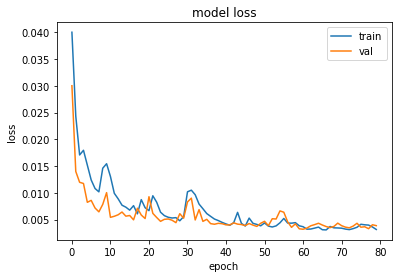

In [31]:
# 六都 : 台北市 + features
x_train1 = np.array(x1[0:(312-window_size-3)])
# ; x_train1 = x_train1[:,np.newaxis,:]
y_train1_4wk = []
y_train1_4wk.append(y1[0:(312-window_size-3)])
y_train1_4wk.append(y1[1:(312-window_size-2)])
y_train1_4wk.append(y1[2:(312-window_size-1)])
y_train1_4wk.append(y1[3:(312-window_size)])
y_train1_4wk = np.array(y_train1_4wk).T

x_val1 = np.array(x1[(312-window_size):(365-window_size-3)])
# ; x_val1 = x_val1[:,np.newaxis,:]
y_val1_4wk = []
y_val1_4wk.append(y1[(312-window_size):(365-window_size-3)])
y_val1_4wk.append(y1[(312-window_size+1):(365-window_size-2)])
y_val1_4wk.append(y1[(312-window_size+2):(365-window_size-1)])
y_val1_4wk.append(y1[(312-window_size+3):(365-window_size)])
y_val1_4wk = np.array(y_val1_4wk).T

x_test1 = np.array(x1[(364-window_size):(416-window_size-3)])
# ; x_test1 = x_test1[:,np.newaxis,:]
y_test1_4wk = []
y_test1_4wk.append(y1[(364-window_size):(416-window_size-3)])
y_test1_4wk.append(y1[(364-window_size+1):(416-window_size-2)])
y_test1_4wk.append(y1[(364-window_size+2):(416-window_size-1)])
y_test1_4wk.append(y1[(364-window_size+3):(416-window_size)])
y_test1_4wk = np.array(y_test1_4wk).T

print("x_train size: {}".format(x_train1.shape))
print("y_train_4wk size: {}".format(np.shape(y_train1_4wk)))
print("x_val size: {}".format(x_val1.shape))
print("y_val_4wk size: {}".format(np.shape(y_val1_4wk)))
print("x_test size: {}".format(x_test1.shape))
print("y_test_4wk size: {}".format(np.shape(y_test1_4wk)))

model2_1 = Sequential()
model2_1.add(LSTM(1000, input_shape=(x_train1.shape[1], x_train1.shape[2])))
# model2_1.add(Dropout(0.5))
model2_1.add(Dense(4))
model2_1.compile(loss='mean_squared_error', optimizer='adam')

history2_1 = model2_1.fit(x_train1, y_train1_4wk, epochs=80, batch_size=50, validation_data=(x_val1, y_val1_4wk))


plt.plot(history2_1.history['loss'])
plt.plot(history2_1.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'], loc='upper right')
plt.show()

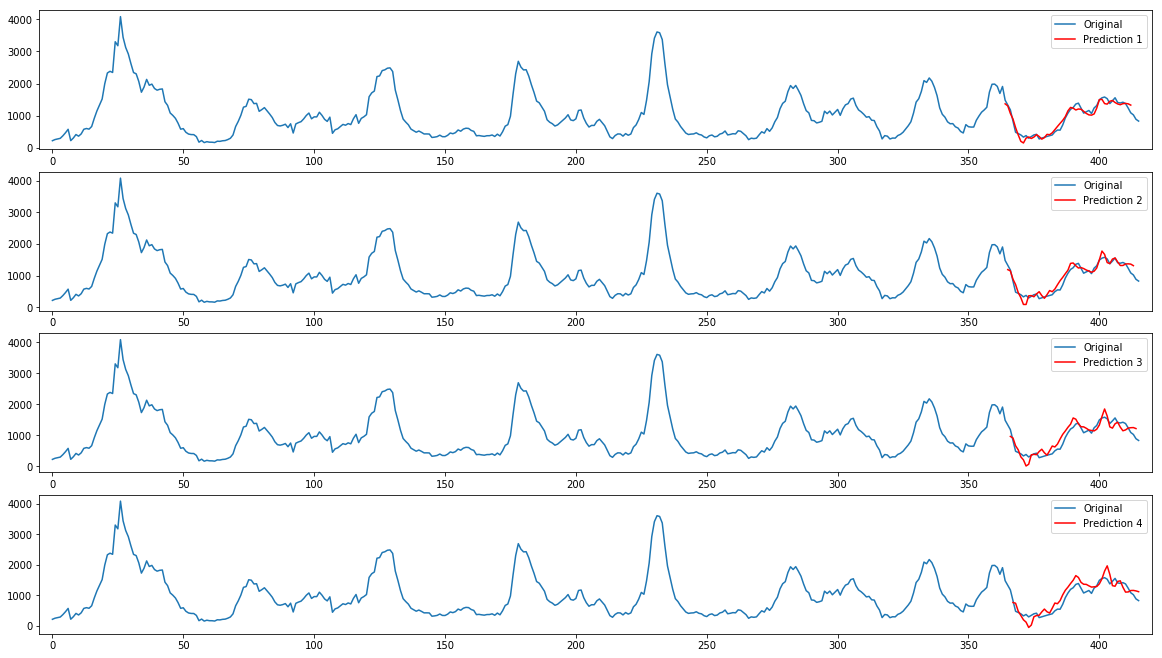

In [42]:
time_diff = 53+52+1   # 2008yr, 2009yr, 2014yr
plt.figure(figsize=(16, 9))

plt.subplot(4,1,1)
plt.plot(scaler.inverse_transform(data_enter1.n_enter.values.reshape(len(data_enter1.n_enter),1)), 
         label='Original') ; plt.xlim(-5, 420)
plt.plot([x for x in range(470-time_diff, 522-time_diff-3)], scaler.inverse_transform(model2_1.predict(x_test1))[:,0],
         'r', label='Prediction 1')
plt.legend(fontsize=10, loc=1)

plt.subplot(4,1,2)
plt.plot(scaler.inverse_transform(data_enter1.n_enter.values.reshape(len(data_enter1.n_enter),1)), 
         label='Original') ; plt.xlim(-5, 420)
plt.plot([x for x in range(470-time_diff+1, 522-time_diff-2)], scaler.inverse_transform(model2_1.predict(x_test1))[:,1],
         'r', label='Prediction 2')
plt.legend(fontsize=10, loc=1)

plt.subplot(4,1,3)
plt.plot(scaler.inverse_transform(data_enter1.n_enter.values.reshape(len(data_enter1.n_enter),1)), 
         label='Original') ; plt.xlim(-5, 420)
plt.plot([x for x in range(470-time_diff+2, 522-time_diff-1)], scaler.inverse_transform(model2_1.predict(x_test1))[:,2],
         'r', label='Prediction 3')
plt.legend(fontsize=10, loc=1)

plt.subplot(4,1,4)
plt.plot(scaler.inverse_transform(data_enter1.n_enter.values.reshape(len(data_enter1.n_enter),1)), 
         label='Original') ; plt.xlim(-5, 420)
plt.plot([x for x in range(470-time_diff+3, 522-time_diff)], scaler.inverse_transform(model2_1.predict(x_test1))[:,3],
         'r', label='Prediction 4')
plt.legend(fontsize=10, loc=1)

# plt.xlabel('Time Step', size=16)
# plt.ylabel('Patient', size=16)
plt.tight_layout(0.2)  # 使subplot不會擠在一起
# plt.savefig('LSTM_Taipei_with_features.png')

In [33]:
# 以 X validation最後一筆去預測接下來四週各別的腸病毒感染人次
print(scaler.inverse_transform(model2_1.predict(x_test1[0][np.newaxis,:,:])))
print('未來第一週的腸病毒感染人次: {}'.format(int(round(scaler.inverse_transform(model2_1.predict(x_test1[0][np.newaxis,:,:]))[0,0]))))
print('未來第二週的腸病毒感染人次: {}'.format(int(round(scaler.inverse_transform(model2_1.predict(x_test1[0][np.newaxis,:,:]))[0,1]))))
print('未來第三週的腸病毒感染人次: {}'.format(int(round(scaler.inverse_transform(model2_1.predict(x_test1[0][np.newaxis,:,:]))[0,2]))))
print('未來第四週的腸病毒感染人次: {}'.format(int(round(scaler.inverse_transform(model2_1.predict(x_test1[0][np.newaxis,:,:]))[0,3]))))
print(scaler.inverse_transform(y_test1_4wk[0][np.newaxis,:]))

# RMSE for wk1
y_true_wk1 = scaler.inverse_transform(y_test1_4wk[:,0][np.newaxis,:])
y_pred_wk1 = scaler.inverse_transform(model2_1.predict(x_test1)[:,0][np.newaxis,:])
print('RMSE: {:.3f}'.format((metrics.mean_squared_error(y_true_wk1, y_pred_wk1))**0.5))

# RMSE for wk2
y_true_wk2 = scaler.inverse_transform(y_test1_4wk[:,1][np.newaxis,:])
y_pred_wk2 = scaler.inverse_transform(model2_1.predict(x_test1)[:,1][np.newaxis,:])
print('RMSE: {:.3f}'.format((metrics.mean_squared_error(y_true_wk2, y_pred_wk2))**0.5))

# RMSE for wk3
y_true_wk3 = scaler.inverse_transform(y_test1_4wk[:,2][np.newaxis,:])
y_pred_wk3 = scaler.inverse_transform(model2_1.predict(x_test1)[:,2][np.newaxis,:])
print('RMSE: {:.3f}'.format((metrics.mean_squared_error(y_true_wk3, y_pred_wk3))**0.5))

# RMSE for wk4
y_true_wk4 = scaler.inverse_transform(y_test1_4wk[:,3][np.newaxis,:])
y_pred_wk4 = scaler.inverse_transform(model2_1.predict(x_test1)[:,3][np.newaxis,:])
print('RMSE: {:.3f}'.format((metrics.mean_squared_error(y_true_wk4, y_pred_wk4))**0.5))

[[ 1368.57080078  1192.88696289   961.39672852   769.16326904]]
未來第一週的腸病毒感染人次: 1369
未來第二週的腸病毒感染人次: 1193
未來第三週的腸病毒感染人次: 961
未來第四週的腸病毒感染人次: 769
[[ 1483.  1330.  1181.   834.]]
RMSE: 107.819
RMSE: 137.802
RMSE: 179.297
RMSE: 206.214


In [41]:
print ('未來第一周的誤差率', "%.2f" % np.mean(np.abs((y_pred_wk1-y_true_wk1)/y_true_wk1*100)), '%')
print ('未來第二周的誤差率', "%.2f" % np.mean(np.abs((y_pred_wk2-y_true_wk2)/y_true_wk2*100)), '%')
print ('未來第三周的誤差率', "%.2f" % np.mean(np.abs((y_pred_wk3-y_true_wk3)/y_true_wk3*100)), '%')
print ('未來第四周的誤差率', "%.2f" % np.mean(np.abs((y_pred_wk4-y_true_wk4)/y_true_wk4*100)), '%')

未來第一周的誤差率 12.21 %
未來第二周的誤差率 17.08 %
未來第三周的誤差率 22.83 %
未來第四周的誤差率 26.63 %


In [43]:
# Model Save
model2_1.save('mymodel.h5')
model2_1.save_weights('mymodel_weights.h5')

### Exploratory Data Analysis

In [37]:
data_enter1.head()

,YearWeek,n_enter,trend,max_temp,min_temp,mean_temp,mean_humid,popul_0_4,pm25_value,pm10_value,CH4_value,CO_value,NO2_value,O3_value,SO2_value,vacation
0,2009.53,0.015047,0.038462,0.181029,0.215686,0.201842,0.694800,0.018853,0.690104,0.624242,0.326874,0.342208,0.491927,0.157231,0.236949,1
1,2010.01,0.024229,0.038462,0.187041,0.196833,0.174885,0.805082,0.018021,0.706163,0.487446,0.507358,0.287007,0.520245,0.062518,0.205446,1
2,2010.02,0.029074,0.033654,0.126920,0.058824,0.107767,0.377671,0.016423,0.400815,0.319697,0.268646,0.222886,0.400923,0.263588,0.163366,1
3,2010.03,0.033920,0.028846,0.360721,0.295626,0.338925,0.554111,0.014781,0.443576,0.477922,0.527278,0.386049,0.675441,0.133976,0.309631,1
4,2010.04,0.054068,0.024038,0.338009,0.307692,0.321525,0.642899,0.013161,0.679688,0.545238,0.522774,0.439297,0.720987,0.217192,0.254950,1


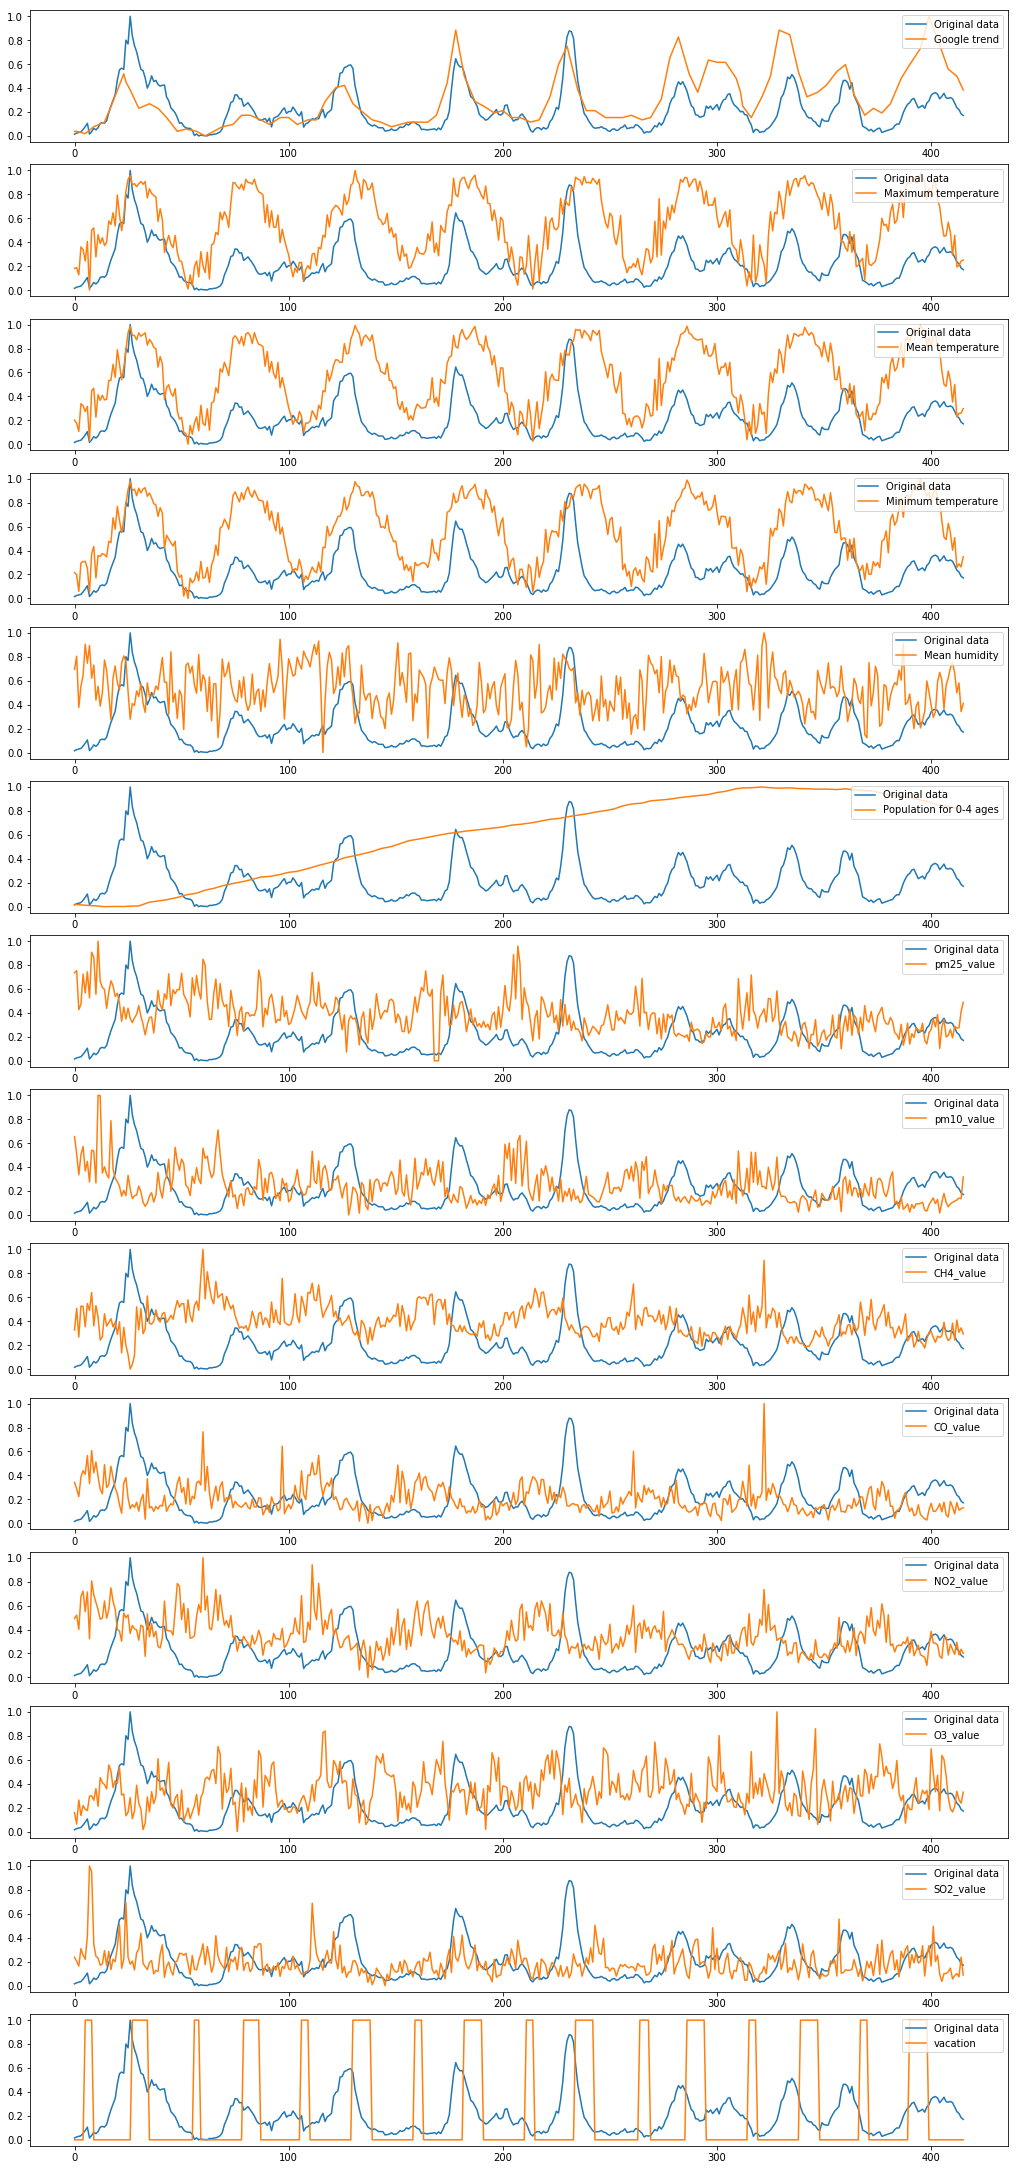

In [32]:
N_features = 14

plt.figure(figsize=(14, 30))
plt.subplot(N_features,1,1)
plt.plot(data_enter1.n_enter, label='Original data') ; plt.plot(data_enter1.trend, label='Google trend') ; plt.legend(fontsize=10, loc=1)

plt.subplot(N_features,1,2)
plt.plot(data_enter1.n_enter, label='Original data') ; plt.plot(data_enter1.max_temp, label='Maximum temperature') ; plt.legend(fontsize=10, loc=1)

plt.subplot(N_features,1,3)
plt.plot(data_enter1.n_enter, label='Original data') ; plt.plot(data_enter1.mean_temp, label='Mean temperature') ; plt.legend(fontsize=10, loc=1)

plt.subplot(N_features,1,4)
plt.plot(data_enter1.n_enter, label='Original data') ; plt.plot(data_enter1.min_temp, label='Minimum temperature') ; plt.legend(fontsize=10, loc=1)

plt.subplot(N_features,1,5)
plt.plot(data_enter1.n_enter, label='Original data') ; plt.plot(data_enter1.mean_humid, label='Mean humidity') ; plt.legend(fontsize=10, loc=1)

plt.subplot(N_features,1,6)
plt.plot(data_enter1.n_enter, label='Original data') ; plt.plot(data_enter1.popul_0_4, label='Population for 0-4 ages') ; plt.legend(fontsize=10, loc=1)


plt.subplot(N_features,1,7)
plt.plot(data_enter1.n_enter, label='Original data') ; plt.plot(data_enter1.pm25_value, label='pm25_value') ; plt.legend(fontsize=10, loc=1)

plt.subplot(N_features,1,8)
plt.plot(data_enter1.n_enter, label='Original data') ; plt.plot(data_enter1.pm10_value, label='pm10_value') ; plt.legend(fontsize=10, loc=1)

plt.subplot(N_features,1,9)
plt.plot(data_enter1.n_enter, label='Original data') ; plt.plot(data_enter1.CH4_value, label='CH4_value') ; plt.legend(fontsize=10, loc=1)

plt.subplot(N_features,1,10)
plt.plot(data_enter1.n_enter, label='Original data') ; plt.plot(data_enter1.CO_value, label='CO_value') ; plt.legend(fontsize=10, loc=1)

plt.subplot(N_features,1,11)
plt.plot(data_enter1.n_enter, label='Original data') ; plt.plot(data_enter1.NO2_value, label='NO2_value') ; plt.legend(fontsize=10, loc=1)

plt.subplot(N_features,1,12)
plt.plot(data_enter1.n_enter, label='Original data') ; plt.plot(data_enter1.O3_value, label='O3_value') ; plt.legend(fontsize=10, loc=1)

plt.subplot(N_features,1,13)
plt.plot(data_enter1.n_enter, label='Original data') ; plt.plot(data_enter1.SO2_value, label='SO2_value') ; plt.legend(fontsize=10, loc=1)


plt.subplot(N_features,1,14)
plt.plot(data_enter1.n_enter, label='Original data') ; plt.plot(data_enter1.vacation, label='vacation') ; plt.legend(fontsize=10, loc=1)

plt.tight_layout(0.2)  # 使subplot不會擠在一起
# plt.savefig('EDA_.png')

In [33]:
# 有做Normalization
print('Spearman Correlation for Google trend: corr = {:.3f}'.format(scipy.stats.stats.spearmanr(data_enter1.n_enter, data_enter1.trend)[0]),
      '(p = {:.2e})'.format(scipy.stats.stats.spearmanr(data_enter1.n_enter, data_enter1.trend)[1]))
print('Spearman Correlation for Maximum temperature: corr = {:.3f}'.format(scipy.stats.stats.spearmanr(data_enter1.n_enter, data_enter1.max_temp)[0]),
      '(p = {:.2e})'.format(scipy.stats.stats.spearmanr(data_enter1.n_enter, data_enter1.max_temp)[1]))
print('Spearman Correlation for Mean temperature: corr = {:.3f}'.format(scipy.stats.stats.spearmanr(data_enter1.n_enter, data_enter1.mean_temp)[0]),
      '(p = {:.2e})'.format(scipy.stats.stats.spearmanr(data_enter1.n_enter, data_enter1.mean_temp)[1]))
print('Spearman Correlation for Minimum temperature: corr = {:.3f}'.format(scipy.stats.stats.spearmanr(data_enter1.n_enter, data_enter1.min_temp)[0]),
      '(p = {:.2e})'.format(scipy.stats.stats.spearmanr(data_enter1.n_enter, data_enter1.min_temp)[1]))
print('Spearman Correlation for Mean humidity: corr = {:.3f}'.format(scipy.stats.stats.spearmanr(data_enter1.n_enter, data_enter1.mean_humid)[0]),
      '(p = {:.2e})'.format(scipy.stats.stats.spearmanr(data_enter1.n_enter, data_enter1.mean_humid)[1]))
print('Spearman Correlation for Population for 0-4 ages: corr = {:.3f}'.format(scipy.stats.stats.spearmanr(data_enter1.n_enter, data_enter1.popul_0_4)[0]),
      '(p = {:.2e})'.format(scipy.stats.stats.spearmanr(data_enter1.n_enter, data_enter1.popul_0_4)[1]))
print('Spearman Correlation for pm25_value: corr = {:.3f}'.format(scipy.stats.stats.spearmanr(data_enter1.n_enter, data_enter1.pm25_value)[0]),
      '(p = {:.2e})'.format(scipy.stats.stats.spearmanr(data_enter1.n_enter, data_enter1.pm25_value)[1]))
print('Spearman Correlation for pm10_value: corr = {:.3f}'.format(scipy.stats.stats.spearmanr(data_enter1.n_enter, data_enter1.pm10_value)[0]),
      '(p = {:.2e})'.format(scipy.stats.stats.spearmanr(data_enter1.n_enter, data_enter1.pm10_value)[1]))
print('Spearman Correlation for CH4_value: corr = {:.3f}'.format(scipy.stats.stats.spearmanr(data_enter1.n_enter, data_enter1.CH4_value)[0]),
      '(p = {:.2e})'.format(scipy.stats.stats.spearmanr(data_enter1.n_enter, data_enter1.CH4_value)[1]))
print('Spearman Correlation for CO_value: corr = {:.3f}'.format(scipy.stats.stats.spearmanr(data_enter1.n_enter, data_enter1.CO_value)[0]),
      '(p = {:.2e})'.format(scipy.stats.stats.spearmanr(data_enter1.n_enter, data_enter1.CO_value)[1]))
print('Spearman Correlation for NO2_value: corr = {:.3f}'.format(scipy.stats.stats.spearmanr(data_enter1.n_enter, data_enter1.NO2_value)[0]),
      '(p = {:.2e})'.format(scipy.stats.stats.spearmanr(data_enter1.n_enter, data_enter1.NO2_value)[1]))
print('Spearman Correlation for O3_value: corr = {:.3f}'.format(scipy.stats.stats.spearmanr(data_enter1.n_enter, data_enter1.O3_value)[0]),
      '(p = {:.2e})'.format(scipy.stats.stats.spearmanr(data_enter1.n_enter, data_enter1.O3_value)[1]))
print('Spearman Correlation for SO2_value: corr = {:.3f}'.format(scipy.stats.stats.spearmanr(data_enter1.n_enter, data_enter1.SO2_value)[0]),
      '(p = {:.2e})'.format(scipy.stats.stats.spearmanr(data_enter1.n_enter, data_enter1.SO2_value)[1]))
print('Spearman Correlation for Vacation: corr = {:.3f}'.format(scipy.stats.stats.spearmanr(data_enter1.n_enter, data_enter1.vacation)[0]),
      '(p = {:.2e})'.format(scipy.stats.stats.spearmanr(data_enter1.n_enter, data_enter1.vacation)[1]))

Spearman Correlation for Google trend: corr = 0.657 (p = 1.10e-52)
Spearman Correlation for Maximum temperature: corr = 0.546 (p = 1.05e-33)
Spearman Correlation for Mean temperature: corr = 0.568 (p = 6.00e-37)
Spearman Correlation for Minimum temperature: corr = 0.581 (p = 6.56e-39)
Spearman Correlation for Mean humidity: corr = -0.012 (p = 8.02e-01)
Spearman Correlation for Population for 0-4 ages: corr = 0.007 (p = 8.92e-01)
Spearman Correlation for pm25_value: corr = -0.277 (p = 8.73e-09)
Spearman Correlation for pm10_value: corr = -0.441 (p = 3.13e-21)
Spearman Correlation for CH4_value: corr = -0.430 (p = 3.51e-20)
Spearman Correlation for CO_value: corr = -0.372 (p = 4.06e-15)
Spearman Correlation for NO2_value: corr = -0.341 (p = 8.18e-13)
Spearman Correlation for O3_value: corr = -0.200 (p = 4.11e-05)
Spearman Correlation for SO2_value: corr = 0.049 (p = 3.17e-01)
Spearman Correlation for Vacation: corr = 0.034 (p = 4.88e-01)


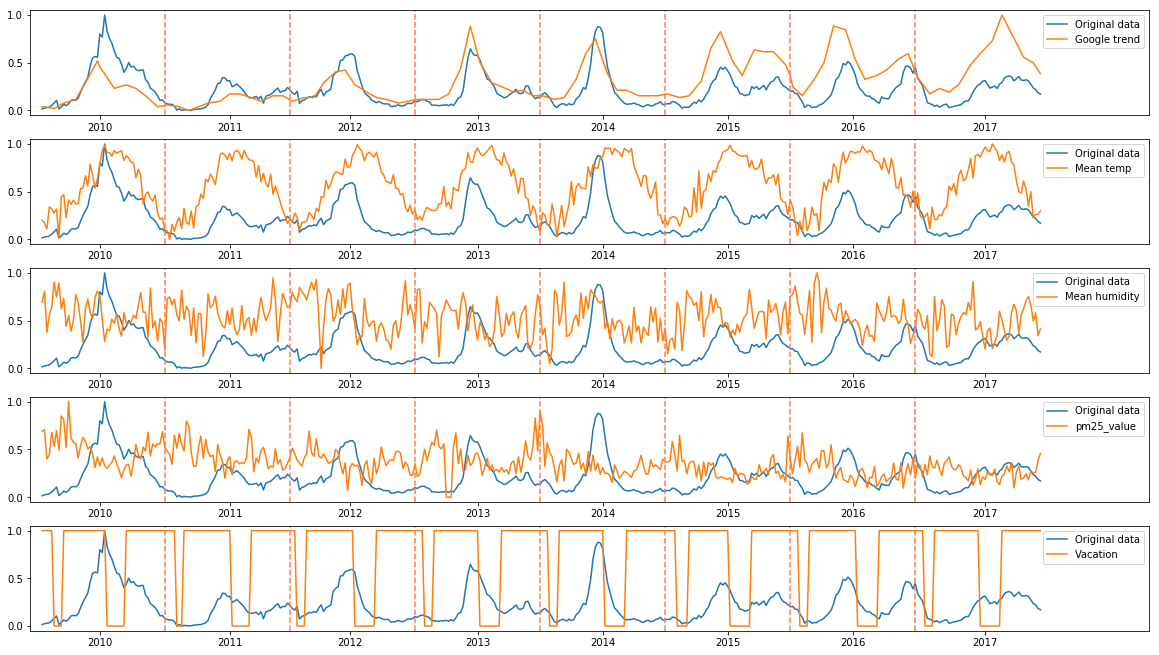

In [45]:
N_features = 5
every_year_week = [51, 103, 155, 207, 259, 311, 363]

plt.figure(figsize=(16, 9))
plt.subplot(N_features,1,1)
plt.plot(data_enter1.n_enter, label='Original data') ; plt.plot(data_enter1.trend, label='Google trend') ; plt.legend(fontsize=10, loc=1)
plt.xlim(-5,460) ; plt.yticks(np.arange(0,1.01,0.5))
plt.xticks([24, 78, 128, 181, 233, 285, 337, 392], ('2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'))
for yw in every_year_week:
    plt.axvline(x=yw, color='coral', linestyle='--')

plt.subplot(N_features,1,2)
plt.plot(data_enter1.n_enter, label='Original data') ; plt.plot(data_enter1.mean_temp, label='Mean temp') ; plt.legend(fontsize=10, loc=1)
plt.xlim(-5,460) ; plt.yticks(np.arange(0,1.01,0.5))
plt.xticks([24, 78, 128, 181, 233, 285, 337, 392], ('2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'))
for yw in every_year_week:
    plt.axvline(x=yw, color='coral', linestyle='--')

plt.subplot(N_features,1,3)
plt.plot(data_enter1.n_enter, label='Original data') ; plt.plot(data_enter1.mean_humid, label='Mean humidity') ; plt.legend(fontsize=10, loc=1)
plt.xlim(-5,460) ; plt.yticks(np.arange(0,1.01,0.5))
plt.xticks([24, 78, 128, 181, 233, 285, 337, 392], ('2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'))
for yw in every_year_week:
    plt.axvline(x=yw, color='coral', linestyle='--')

plt.subplot(N_features,1,4)
plt.plot(data_enter1.n_enter, label='Original data') ; plt.plot(data_enter1.pm25_value, label='pm25_value') ; plt.legend(fontsize=10, loc=1)
plt.xlim(-5,460) ; plt.yticks(np.arange(0,1.01,0.5))
plt.xticks([24, 78, 128, 181, 233, 285, 337, 392], ('2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'))
for yw in every_year_week:
    plt.axvline(x=yw, color='coral', linestyle='--')

plt.subplot(N_features,1,5)
plt.plot(data_enter1.n_enter, label='Original data') ; plt.plot(data_enter1.vacation, label='Vacation') ; plt.legend(fontsize=10, loc=1)
plt.xlim(-5,460) ; plt.yticks(np.arange(0,1.01,0.5))
plt.xticks([24, 78, 128, 181, 233, 285, 337, 392], ('2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'))
for yw in every_year_week:
    plt.axvline(x=yw, color='coral', linestyle='--')


plt.tight_layout(0.35)  # 使subplot不會擠在一起
# plt.savefig('EDA_five_features.png')